TODO:
 - ~~Add classification part~~
 - Edit plot insights part, add better plots, explore correlation further and write a report

***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import mutual_info_regression, chi2, SelectKBest, VarianceThreshold, f_regression

import statsmodels.api as sm
import seaborn as sb
from scipy.stats import norm
import scipy.stats as stats

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler

from operator import itemgetter

from sklearn.model_selection import KFold, GridSearchCV

In [5]:
DATA_PATH = "../data/"
MAX_LEN = len(max(os.listdir(DATA_PATH), key=len))

In [8]:
list_of_files = os.listdir(DATA_PATH)

In [9]:
for file in list_of_files:
    file_size = os.stat(DATA_PATH + file).st_size / 1e6
    # print(file + ": \t\t" + str(round(file_size, 2)) + " MiB")
    print(f"{file:>{MAX_LEN}}{'MiB':>6} {file_size}")


  08_temp_out.csv   MiB 0.19678
    06_rhu_in.csv   MiB 1.857203
       01_occ.csv   MiB 1.426732
   05_temp_in.csv   MiB 2.070381
07_rad_global.csv   MiB 0.18243
       11_wdi.csv   MiB 0.191474
     03_light.csv   MiB 1.19153
       02_win.csv   MiB 1.96899
      04_plug.csv   MiB 1.521364
   09_rhu_out.csv   MiB 0.18412
       10_wsp.csv   MiB 0.200581


In [6]:
for file in list_of_files:
    df = pd.read_csv(DATA_PATH+ file)
    print("File: ", file, "| Shape: ", df.shape)

File:  08_temp_out.csv | Shape:  (8760, 2)
File:  06_rhu_in.csv | Shape:  (35040, 8)
File:  01_occ.csv | Shape:  (35040, 10)


File:  05_temp_in.csv | Shape:  (35040, 8)
File:  07_rad_global.csv | Shape:  (8760, 2)
File:  11_wdi.csv | Shape:  (8760, 2)
File:  03_light.csv | Shape:  (35040, 9)
File:  02_win.csv | Shape:  (35040, 20)
File:  04_plug.csv | Shape:  (35040, 9)
File:  09_rhu_out.csv | Shape:  (8760, 2)
File:  10_wsp.csv | Shape:  (8760, 2)


In [7]:
presence_df         = pd.read_csv(DATA_PATH + '01_occ.csv')
window_state_df     = pd.read_csv(DATA_PATH + '02_win.csv')
light_state_df      = pd.read_csv(DATA_PATH + '03_light.csv')
equipment_power_df  = pd.read_csv(DATA_PATH + '04_plug.csv')
indoor_temp_df      = pd.read_csv(DATA_PATH + '05_temp_in.csv')
indoor_humi_df      = pd.read_csv(DATA_PATH + '06_rhu_in.csv')
glob_rad_df         = pd.read_csv(DATA_PATH + '07_rad_global.csv')
outside_temp_df     = pd.read_csv(DATA_PATH + '08_temp_out.csv')
outside_humi_df     = pd.read_csv(DATA_PATH + '09_rhu_out.csv')
wind_speed_df       = pd.read_csv(DATA_PATH + '10_wsp.csv')
wind_dir_df         = pd.read_csv(DATA_PATH + '11_wdi.csv')

In [8]:
dataframe_list = [
    presence_df,
    window_state_df,
    light_state_df,
    equipment_power_df,
    indoor_temp_df,
    indoor_humi_df,
    glob_rad_df,
    outside_temp_df,
    outside_humi_df,
    wind_speed_df,
    wind_dir_df
]

### Exploratory Data Analysis

In [9]:
def create_rename_dictionary(columns, prefix) -> dict:
    recnik = dict()
    for column in columns:
        if "timestamp" in column:
            recnik[column] = column.split(' ')[0].lower()
            continue
        # new_col_name = prefix + "_" + column.split(' ')[0]
        recnik[column] = prefix + "_" + column.split(' ')[0].lower()

    return recnik

In [10]:
presence_df.rename(create_rename_dictionary(presence_df.columns, 'pres'), axis=1, inplace=True)
window_state_df.rename(create_rename_dictionary(window_state_df.columns, 'window'), axis=1, inplace=True)
light_state_df.rename(create_rename_dictionary(light_state_df.columns, 'light'), axis=1, inplace=True)
equipment_power_df.rename(create_rename_dictionary(equipment_power_df.columns, 'power'), axis=1, inplace=True)
indoor_temp_df.rename(create_rename_dictionary(indoor_temp_df.columns, 'temp_in'), axis=1, inplace=True)
indoor_humi_df.rename(create_rename_dictionary(indoor_humi_df.columns, 'humi_in'), axis=1, inplace=True)
glob_rad_df.rename(create_rename_dictionary(glob_rad_df.columns, 'rad'), axis=1, inplace=True)
outside_temp_df.rename(create_rename_dictionary(outside_temp_df.columns, 'temp_out'), axis=1, inplace=True)
outside_humi_df.rename(create_rename_dictionary(outside_humi_df.columns, 'humi_out'), axis=1, inplace=True)
wind_speed_df.rename(create_rename_dictionary(wind_speed_df.columns, 'wsp'), axis=1, inplace=True)
wind_dir_df.rename(create_rename_dictionary(wind_dir_df.columns, 'wdi'), axis=1, inplace=True)

In [11]:
presence_df.loc[(presence_df['pres_ki'] != 0) & (presence_df['pres_ki'] != 1), :]

,timestamp,pres_ki,pres_o1_1,pres_o1_2,pres_o1_3,pres_o1_4,pres_o1_5,pres_o2,pres_o3,pres_o4
119,02/01/2013 05:45,0.08,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.07
132,02/01/2013 09:00,0.04,0.12,0.01,0.00,0.00,0.00,0.00,0.00,0.00
133,02/01/2013 09:15,0.09,0.41,0.12,0.00,0.00,0.00,0.00,0.00,0.00
136,02/01/2013 10:00,0.39,0.51,0.12,0.00,0.00,0.00,0.00,0.00,0.00
139,02/01/2013 10:45,0.17,0.86,0.40,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
34886,30/12/2013 09:30,0.16,0.15,0.10,0.07,0.07,0.08,0.08,0.07,0.07
34903,30/12/2013 13:45,0.10,0.00,0.00,0.41,0.72,0.00,0.00,0.00,0.00
34904,30/12/2013 14:00,0.12,0.00,0.00,0.34,0.99,0.00,0.00,0.00,0.00
34905,30/12/2013 14:15,0.01,0.00,0.00,0.18,1.00,0.00,0.00,0.00,0.00


In [12]:
window_state_df.loc[(window_state_df['window_ki'] != 0) & (window_state_df['window_ki'] != 1), :]

,timestamp,window_ki,window_o1_1,window_o1_2,window_o1_3,window_o1_4,window_o2_1,window_o2_2,window_o3_1,window_o3_2,window_o3_3,window_o3_4,window_o4_1,window_o4_2,window_mr_1,window_mr_2,window_mr_3,window_mr_4,window_mr_5,window_mr_6
916,10/01/2013 13:00,0.48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.00,1.00,1.0,1.00
918,10/01/2013 13:30,0.14,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.00,1.00,1.0,1.00
2050,22/01/2013 08:30,0.65,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.00,1.00,1.0,1.00
2051,22/01/2013 08:45,0.43,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.00,1.00,1.0,1.00
12715,13/05/2013 10:45,0.66,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.00,1.00,1.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33350,14/12/2013 09:30,0.69,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.00,1.00,1.0,1.00
33352,14/12/2013 10:00,0.82,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.00,1.00,1.0,1.00
33375,14/12/2013 15:45,0.26,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.00,0.39,1.0,1.00
33944,20/12/2013 14:00,0.60,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.63,1.0,0.55,0.53,1.0,0.68


In [13]:
combined_df = pd.DataFrame()
first = True
for dataframe in dataframe_list:
    if first:
        combined_df = dataframe
        first = False
    else:
        combined_df = pd.merge(combined_df, dataframe, how='left', on='timestamp')
    del dataframe

In [14]:
combined_df.shape

(35040, 64)

In [15]:
combined_df.isna().sum()

timestamp               0
pres_ki                 0
pres_o1_1               0
pres_o1_2               0
pres_o1_3               0
                    ...  
rad_gh              26280
temp_out_tempout    26280
humi_out_rh         26280
wsp_wind            26280
wdi_wind            26280
Length: 64, dtype: int64

In [16]:
combined_df.fillna(method='ffill', axis=0, inplace=True)

In [17]:
combined_df.isna().sum().sum()

0

In [18]:
df = combined_df.copy(deep=True)

In [19]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [20]:
df.dtypes

timestamp           datetime64[ns]
pres_ki                    float64
pres_o1_1                  float64
pres_o1_2                  float64
pres_o1_3                  float64
                         ...      
rad_gh                     float64
temp_out_tempout           float64
humi_out_rh                float64
wsp_wind                   float64
wdi_wind                   float64
Length: 64, dtype: object

In [21]:
df.loc[:, ['timestamp']]

,timestamp
0,2013-01-01 00:00:00
1,2013-01-01 00:15:00
2,2013-01-01 00:30:00
3,2013-01-01 00:45:00
4,2013-01-01 01:00:00
...,...
35035,2013-12-31 22:45:00
35036,2013-12-31 23:00:00
35037,2013-12-31 23:15:00
35038,2013-12-31 23:30:00


In [22]:
df['year'] = df.timestamp.dt.year
df['month'] = df.timestamp.dt.month
df['day'] = df.timestamp.dt.day
df['hour'] = df.timestamp.dt.hour
df['minute'] = df.timestamp.dt.minute
df['day_name'] = df.timestamp.dt.day_name()

In [23]:
df.head()

,timestamp,pres_ki,pres_o1_1,pres_o1_2,pres_o1_3,pres_o1_4,pres_o1_5,pres_o2,pres_o3,pres_o4,...,temp_out_tempout,humi_out_rh,wsp_wind,wdi_wind,year,month,day,hour,minute,day_name
0,2013-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.6,97.0,0.45,37.0,2013,1,1,0,0,Tuesday
1,2013-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.6,97.0,0.45,37.0,2013,1,1,0,15,Tuesday
2,2013-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.6,97.0,0.45,37.0,2013,1,1,0,30,Tuesday
3,2013-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.6,97.0,0.45,37.0,2013,1,1,0,45,Tuesday
4,2013-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.2,99.0,0.82,41.0,2013,1,1,1,0,Tuesday


In [24]:
df.drop('timestamp', axis=1, inplace=True)

In [25]:
df.head()

,pres_ki,pres_o1_1,pres_o1_2,pres_o1_3,pres_o1_4,pres_o1_5,pres_o2,pres_o3,pres_o4,window_ki,...,temp_out_tempout,humi_out_rh,wsp_wind,wdi_wind,year,month,day,hour,minute,day_name
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.6,97.0,0.45,37.0,2013,1,1,0,0,Tuesday
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.6,97.0,0.45,37.0,2013,1,1,0,15,Tuesday
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.6,97.0,0.45,37.0,2013,1,1,0,30,Tuesday
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.6,97.0,0.45,37.0,2013,1,1,0,45,Tuesday
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.2,99.0,0.82,41.0,2013,1,1,1,0,Tuesday


In [26]:
df.describe()

,pres_ki,pres_o1_1,pres_o1_2,pres_o1_3,pres_o1_4,pres_o1_5,pres_o2,pres_o3,pres_o4,window_ki,...,rad_gh,temp_out_tempout,humi_out_rh,wsp_wind,wdi_wind,year,month,day,hour,minute
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,...,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.0,35040.000000,35040.000000,35040.000000,35040.000000
mean,0.085819,0.131502,0.158966,0.161984,0.190070,0.169380,0.169380,0.152774,0.129179,0.953500,...,136.411644,11.480788,68.947146,2.824526,203.984703,2013.0,6.526027,15.720548,11.500000,22.500000
std,0.207412,0.291381,0.324744,0.336210,0.363464,0.340585,0.340585,0.326892,0.299173,0.208838,...,221.263427,8.899182,16.836595,1.620725,89.528737,0.0,3.447901,8.796373,6.922285,16.770749
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-7.400000,14.000000,0.000000,0.000000,2013.0,1.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,3.900000,57.000000,1.640000,128.000000,2013.0,4.000000,8.000000,5.750000,11.250000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,7.000000,11.400000,70.000000,2.550000,225.000000,2013.0,7.000000,16.000000,11.500000,22.500000
75%,0.000000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,1.000000,...,179.250000,18.200000,82.000000,3.760000,283.000000,2013.0,10.000000,23.000000,17.250000,33.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,957.000000,38.800000,100.000000,9.690000,346.000000,2013.0,12.000000,31.000000,23.000000,45.000000


In [27]:
df.loc[(df['month'] == 6) & (df['year'] == 2013), ['day', 'day_name']].head()

,day,day_name
480,1,Saturday
481,1,Saturday
482,1,Saturday
483,1,Saturday
484,1,Saturday


In [28]:
df.loc[(df['power_o1_1'] == 0), ['day_name']].value_counts() / df.loc[(df['power_o1_1'] == 0)].shape[0] * 100

day_name 
Tuesday      23.480084
Monday       15.234102
Friday       14.046122
Saturday     13.417191
Sunday       13.417191
Thursday     11.670161
Wednesday     8.735150
dtype: float64

In [29]:
df['power_o1'] = df.loc[:, ['power_o1_1', 'power_o1_2', 'power_o1_3', 'power_o1_4', 'power_o1_5']].mean(axis=1)

In [30]:
df['presence_overall'] = df.loc[:, ['pres_ki', 'pres_o1_1', 'pres_o1_2', 'pres_o1_3', 'pres_o1_4', 'pres_o1_5', 'pres_o2', 'pres_o3', 'pres_o4']].sum(axis=1)
df['presence_overall_mean'] = df.loc[:, ['pres_ki', 'pres_o1_1', 'pres_o1_2', 'pres_o1_3', 'pres_o1_4', 'pres_o1_5', 'pres_o2', 'pres_o3', 'pres_o4']].mean(axis=1)

In [31]:
df['presence_overall'].describe()

count    35040.000000
mean         1.349054
std          2.128568
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max          8.940000
Name: presence_overall, dtype: float64

In [32]:
np.linspace(0, round(max(df['presence_overall']) - df['presence_overall'].std(), 2), 5).tolist()

[0.0, 1.7025, 3.405, 5.1075, 6.81]

In [33]:
# thresholds = [-np.inf, 0, 0.2, 0.4, 0.6, 0.8, np.inf]
thresholds_cum = [-np.inf] + np.linspace(0, round(max(df['presence_overall']) - df['presence_overall'].std(), 2), 5).tolist() + [np.inf]
class_labels = ['absent', 'very low', 'low', 'moderate', 'high', 'very high']

In [34]:
df['class'] = pd.cut(df['presence_overall'], bins=thresholds_cum, labels=class_labels, include_lowest=True)
# df['class_mean'] = pd.cut(df['presence_overall_mean'], bins=thresholds, labels=class_labels, include_lowest=True)

In [35]:
df.loc[df['class'] == 'very high', :]

,pres_ki,pres_o1_1,pres_o1_2,pres_o1_3,pres_o1_4,pres_o1_5,pres_o2,pres_o3,pres_o4,window_ki,...,year,month,day,hour,minute,day_name,power_o1,presence_overall,presence_overall_mean,class
806,0.94,0.93,1.00,1.00,0.87,1.00,1.00,0.09,1.00,1.0,...,2013,9,1,9,30,Sunday,129.870,7.83,0.870000,very high
807,1.00,0.95,0.83,0.95,0.72,1.00,1.00,0.97,0.82,1.0,...,2013,9,1,9,45,Sunday,135.418,8.24,0.915556,very high
808,1.00,0.94,0.97,0.62,0.20,1.00,1.00,0.93,0.90,1.0,...,2013,9,1,10,0,Sunday,132.458,7.56,0.840000,very high
809,0.58,0.54,1.00,1.00,0.00,1.00,1.00,0.94,0.97,1.0,...,2013,9,1,10,15,Sunday,132.388,7.03,0.781111,very high
810,0.63,0.40,1.00,0.89,0.73,1.00,1.00,0.45,0.99,1.0,...,2013,9,1,10,30,Sunday,130.238,7.09,0.787778,very high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33833,0.26,0.77,0.33,0.78,1.00,0.97,0.97,1.00,0.99,1.0,...,2013,12,19,10,15,Thursday,143.460,7.07,0.785556,very high
33943,1.00,0.83,0.73,0.68,0.87,1.00,1.00,0.54,0.31,1.0,...,2013,12,20,13,45,Friday,110.758,6.96,0.773333,very high
33944,0.96,1.00,0.77,1.00,0.93,1.00,1.00,0.64,0.58,0.6,...,2013,12,20,14,0,Friday,111.346,7.88,0.875556,very high
33945,0.88,1.00,0.81,0.98,1.00,1.00,1.00,0.23,0.15,0.0,...,2013,12,20,14,15,Friday,109.014,7.05,0.783333,very high


In [36]:
print(df['class'].value_counts())
# print(df['class_mean'].value_counts())

absent       20519
very low      4303
low           4047
high          2699
moderate      2511
very high      961
Name: class, dtype: int64


TODO: change the way classes are distributed based on the overall presence.

Currently the overall presence is calculated by summing up the presence across all offices and then using using the thresholds that range between -infinity and +infinity assign several class cases (eg. >0.8 => 'very high').

TODO: find mean for presence features and then label the data based on that value.
TODO: plot the distribution for cummulative (summed up presence) value of presence, find min, max, median and then find the proper range/scale for labeling data based on that value.

In [37]:
df['class'].value_counts() / df.shape[0] * 100

absent       58.558790
very low     12.280251
low          11.549658
high          7.702626
moderate      7.166096
very high     2.742580
Name: class, dtype: float64

### Plot insights

#### Corr map

Based on correlation map we can deduce the correlation between the features, most interesting correlations obviously being between presence and other features.

Correlation tells us how eg. presence feature changes compared to some other feature.

Eg. if we have high positive correlation with power, then we can say that the presence increases with the increase in power consumption, which is logical given that the data is based on office which most likely has electronic devices like computers or laptops that consume moderate amount of power while turned on.

In [122]:
corrMatrix = df.corr().round(2)

<AxesSubplot:>

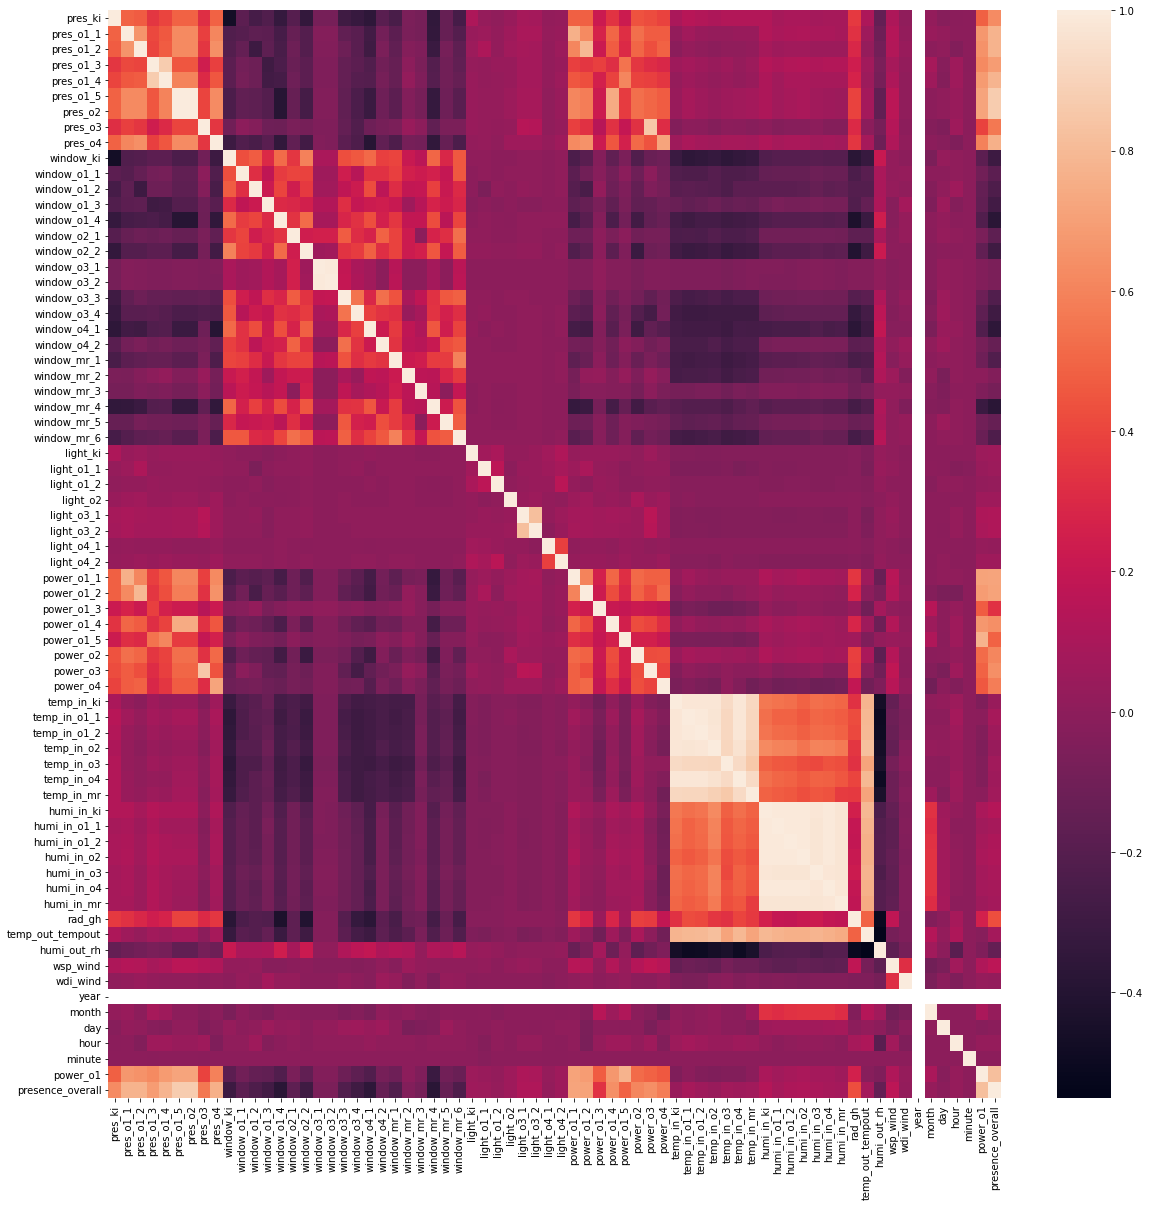

In [126]:
plt.figure(figsize=(20, 20))
sb.heatmap(corrMatrix, annot=False)

#### Hourly information plot

Plotting power consumption, light flicks, overall presence etc. by hour shows us exactly what we'd expect. Flat line until 5:00am - 5:45am when first worker/workers start entering the office, after which it goes up and stays until ~8pm when the workers start leaving their office. 

Office 1 shows high activities from 5am till 8pm which is expected given it's the largest office counting 5 people in it. Other offices tend to follow the similar trend, some starting slightly later and ending slightly sooner.

According to several plots, Saturday and Sunday seem to be the day offs. The power still shows some activity which is an expected scenario given that there's a lot of different electronic devices which could be plugged into the power outlet, some being active during the weekend, eg. employee leaving PC running over the weekend for remote control or some other work being done. There's also fridge that continuously cools the items inside of it, etc.

In [103]:
dfgby_hour = df.groupby(['hour', 'minute']).mean()

In [104]:
dfgby_hour

pres_ki  pres_o1_1  pres_o1_2  pres_o1_3  pres_o1_4  pres_o1_5  \
hour minute                                                                    
0    0       0.000000   0.005479   0.006192   0.035616   0.035616   0.005479   
     15      0.000247   0.005479   0.005534   0.035616   0.035616   0.005479   
     30      0.000000   0.005479   0.005534   0.035863   0.035616   0.005479   
     45      0.000000   0.005479   0.005726   0.035616   0.035616   0.005479   
1    0       0.000000   0.005479   0.005479   0.035616   0.035616   0.005479   
...               ...        ...        ...        ...        ...        ...   
22   45      0.000000   0.005836   0.005479   0.040110   0.041096   0.005671   
23   0       0.000274   0.005671   0.006877   0.039260   0.039479   0.006192   
     15      0.000000   0.005479   0.005479   0.035616   0.035616   0.005479   
     30      0.000247   0.005479   0.005479   0.035616   0.035616   0.005479   
     45      0.000000   0.005479   0.005863   0.035616   0.035616   0.005479   

              pres_o2   pres_o3   pres_o4  window_ki  ...  humi_in_mr  \
hour minute                                           ...               
0    0       0.005479  0.008219  0.005479   0.994521  ...   31.075890   
     15      0.005479  0.008219  0.005479   0.994521  ...   31.070959   
     30      0.005479  0.008247  0.005479   0.994521  ...   31.068767   
     45      0.005479  0.008219  0.005479   0.994521  ...   31.062466   
1    0       0.005479  0.008219  0.005479   0.994521  ...   31.046027   
...               ...       ...       ...        ...  ...         ...   
22   45      0.005671  0.008219  0.005781   0.994521  ...   31.081096   
23   0       0.006192  0.008219  0.005479   0.994521  ...   31.109041   
     15      0.005479  0.008219  0.005479   0.994521  ...   31.102740   
     30      0.005479  0.008219  0.005479   0.994521  ...   31.096986   
     45      0.005479  0.008219  0.005479   0.994521  ...   31.093973   

               rad_gh  temp_out_tempout  humi_out_rh  wsp_wind    wdi_wind  \
hour minute                                                                  
0    0       0.873973         10.237534    73.857534  2.426466  207.904110   
     15      0.873973         10.237534    73.857534  2.426466  207.904110   
     30      0.873973         10.237534    73.857534  2.426466  207.904110   
     45      0.873973         10.237534    73.857534  2.426466  207.904110   
1    0       0.835616          9.929315    74.797260  2.403288  207.934247   
...               ...               ...          ...       ...         ...   
22   45      0.956164         10.937534    71.558904  2.482986  205.868493   
23   0       0.794521         10.597260    72.558904  2.457178  208.819178   
     15      0.794521         10.597260    72.558904  2.457178  208.819178   
     30      0.794521         10.597260    72.558904  2.457178  208.819178   
     45      0.794521         10.597260    72.558904  2.457178  208.819178   

               year     month        day   power_o1  
hour minute                                          
0    0       2013.0  6.526027  15.720548  19.995107  
     15      2013.0  6.526027  15.720548  20.094652  
     30      2013.0  6.526027  15.720548  20.206707  
     45      2013.0  6.526027  15.720548  20.183063  
1    0       2013.0  6.526027  15.720548  20.123178  
...             ...       ...        ...        ...  
22   45      2013.0  6.526027  15.720548  20.309200  
23   0       2013.0  6.526027  15.720548  20.121052  
     15      2013.0  6.526027  15.720548  19.958197  
     30      2013.0  6.526027  15.720548  20.063863  
     45      2013.0  6.526027  15.720548  19.997353  

[96 rows x 67 columns]

In [101]:
dfgby_hour['power_o4']

minute  hour
0       0       11.430137
        1       11.436877
        2       11.438356
        3       11.438356
        4       11.438356
                  ...    
45      19      11.454795
        20      11.454795
        21      11.454795
        22      11.454795
        23      11.454795
Name: power_o4, Length: 96, dtype: float64

In [34]:
df.columns

Index(['pres_ki', 'pres_o1_1', 'pres_o1_2', 'pres_o1_3', 'pres_o1_4',
       'pres_o1_5', 'pres_o2', 'pres_o3', 'pres_o4', 'window_ki',
       'window_o1_1', 'window_o1_2', 'window_o1_3', 'window_o1_4',
       'window_o2_1', 'window_o2_2', 'window_o3_1', 'window_o3_2',
       'window_o3_3', 'window_o3_4', 'window_o4_1', 'window_o4_2',
       'window_mr_1', 'window_mr_2', 'window_mr_3', 'window_mr_4',
       'window_mr_5', 'window_mr_6', 'light_ki', 'light_o1_1', 'light_o1_2',
       'light_o2', 'light_o3_1', 'light_o3_2', 'light_o4_1', 'light_o4_2',
       'power_o1_1', 'power_o1_2', 'power_o1_3', 'power_o1_4', 'power_o1_5',
       'power_o2', 'power_o3', 'power_o4', 'temp_in_ki', 'temp_in_o1_1',
       'temp_in_o1_2', 'temp_in_o2', 'temp_in_o3', 'temp_in_o4', 'temp_in_mr',
       'humi_in_ki', 'humi_in_o1_1', 'humi_in_o1_2', 'humi_in_o2',
       'humi_in_o3', 'humi_in_o4', 'humi_in_mr', 'rad_gh', 'temp_out_tempout',
       'humi_out_rh', 'wsp_wind', 'wdi_wind', 'year', 'month', 'day',

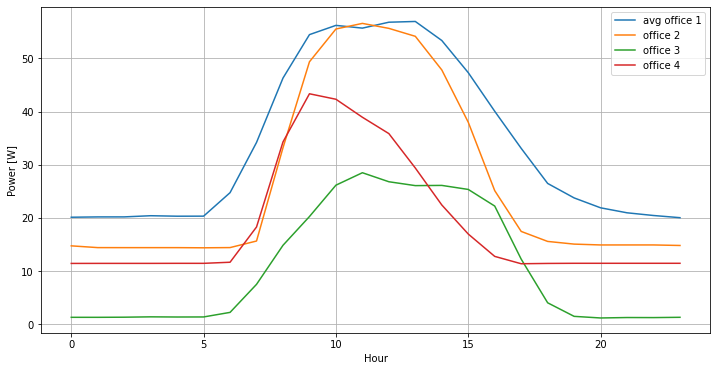

In [31]:
plt.figure(figsize=(12, 6))
df.groupby(['hour'])['power_o1'].mean().plot(label='avg office 1', legend=True)
df.groupby(['hour'])['power_o2'].mean().plot(label='office 2', legend=True)
df.groupby(['hour'])['power_o3'].mean().plot(label='office 3', legend=True)
df.groupby(['hour'])['power_o4'].mean().plot(label='office 4', legend=True)
plt.grid()
plt.xlabel("Hour")
plt.ylabel("Power [W]")
plt.show()

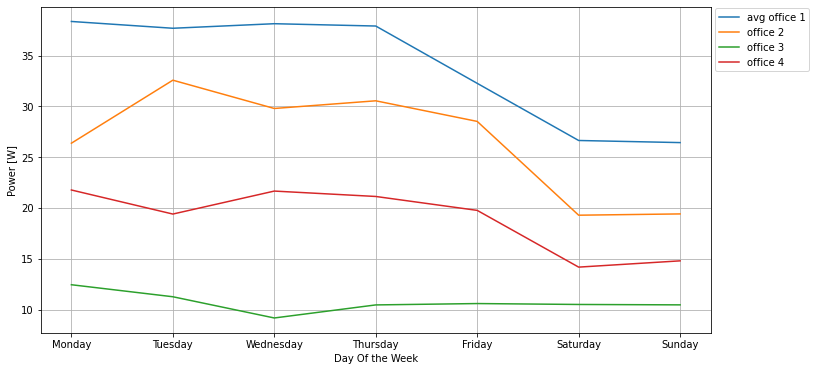

In [36]:
plt.figure(figsize=(12, 6))
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df.groupby(['day_name'])['power_o1'].mean().reindex(cats).plot(label='avg office 1')
df.groupby(['day_name'])['power_o2'].mean().reindex(cats).plot(label='office 2')
df.groupby(['day_name'])['power_o3'].mean().reindex(cats).plot(label='office 3')
df.groupby(['day_name'])['power_o4'].mean().reindex(cats).plot(label='office 4')
plt.legend(loc='upper right', bbox_to_anchor=(1.155, 1.01))
plt.grid()
plt.xlabel("Day Of the Week")
plt.ylabel("Power [W]")
plt.show()

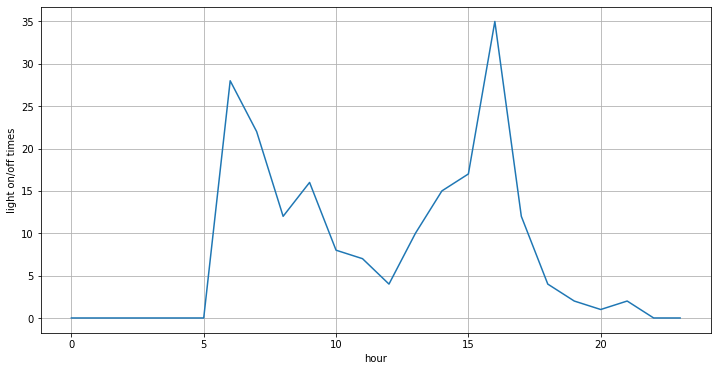

In [37]:
plt.figure(figsize=(12, 6))
df.groupby(['hour'])['light_ki'].sum().plot(label='kitchen')
plt.grid()
plt.xlabel('hour')
plt.ylabel('light on/off times')
plt.show()

In [39]:
dfgby_hour = df.groupby(['hour', 'minute']).mean()

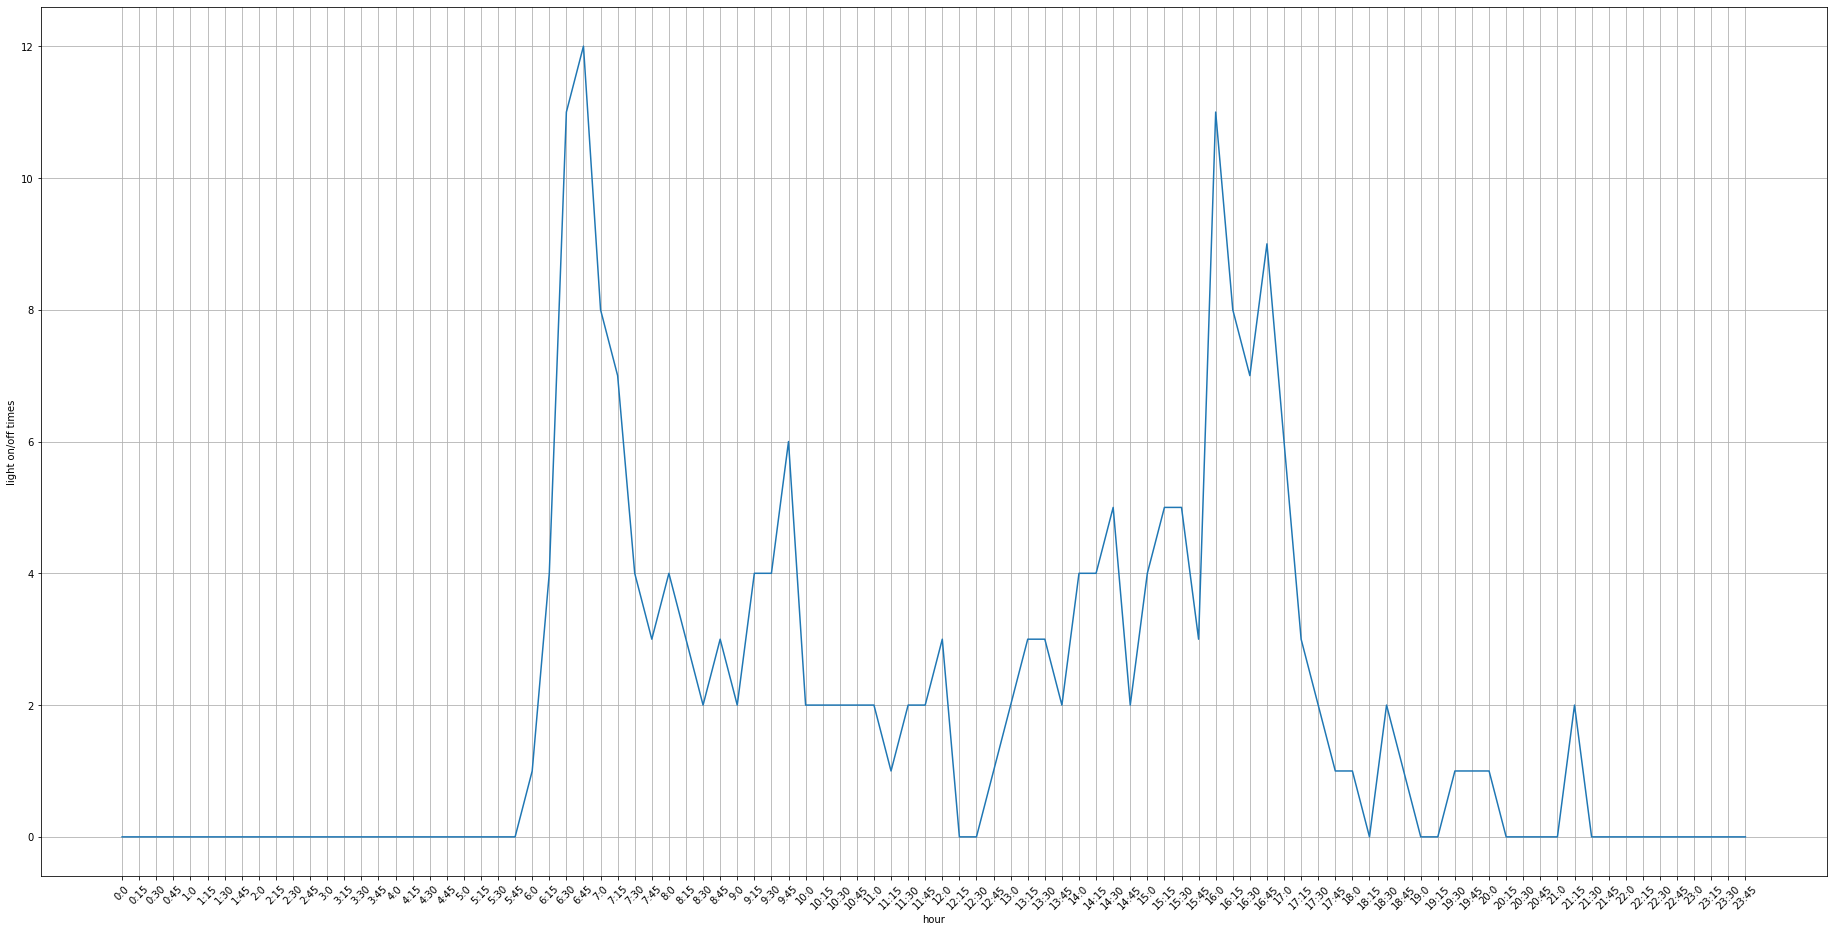

In [40]:
plt.figure(figsize=(32, 16))
df.groupby(['hour', 'minute'])['light_ki'].sum().plot(label='kitchen', )
plt.grid()
plt.xlabel('hour')
plt.ylabel('light on/off times')

hours = dfgby_hour.index.get_level_values('hour').unique()

xticks = []
xtick_labels = []
for hour in hours:
    xticks.extend([(hour, 0), (hour, 15), (hour, 30), (hour, 45)])
    xtick_labels.extend([f"{hour}:{00}", f"{hour}:{15}", f"{hour}:{30}", f"{hour}:{45}"])

plt.xticks(range(len(xticks)), xtick_labels, rotation=45)

plt.show()

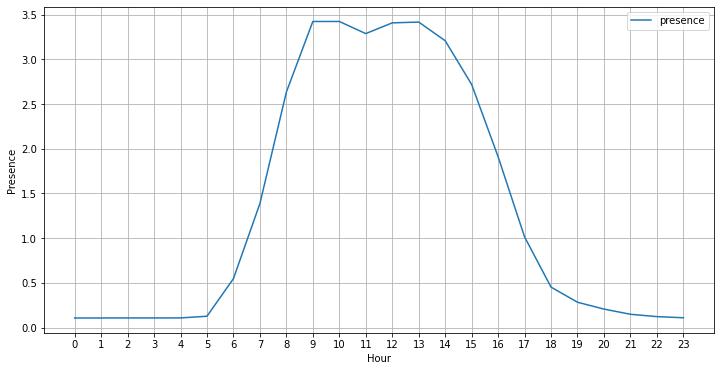

In [142]:
# office: o1
plt.figure(figsize=(12, 6))
df.groupby(['hour'])['presence_overall'].mean().plot(label='presence', legend=True)
plt.grid()
plt.xlabel("Hour")
plt.ylabel("Presence")
plt.xticks(range(24))
plt.show()

#### Normal distribution plot

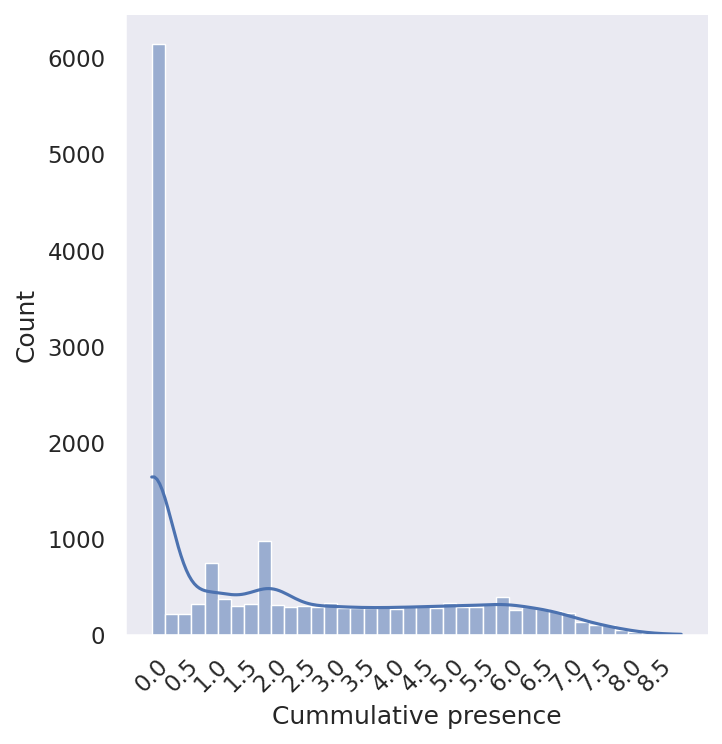

In [158]:
# plt.figure(figsize = (16,20))
# plt.subplot(6,1,1)
p = sb.displot(df.loc[(df.hour > 5) & (df.hour < 22) & (df.day_name != 'Saturday') & (df.day_name != 'Sunday'), 'presence_overall'] ,
                bins=40, 
                kde=True,
                rug=False)
# sb.rugplot(df.loc[(df.hour > 5) & (df.hour < 22) & (df.day_name != 'Saturday') & (df.day_name != 'Sunday'), 'presence_overall'])
plt.grid()
plt.xticks(np.arange(0, 9, 0.5), rotation=45)
plt.xlabel(xlabel='Cummulative presence')
p.fig.set_dpi(150)
plt.show()

<AxesSubplot:xlabel='pres_o3', ylabel='Density'>

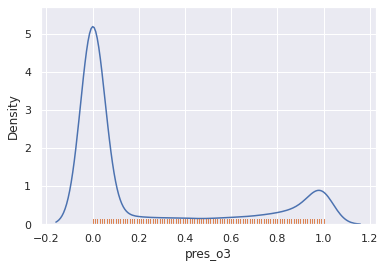

In [127]:
sb.set_theme()
sb.kdeplot(data=df.loc[(df.hour > 5) & (df.hour < 22) & (df.day_name != 'Saturday') & (df.day_name != 'Sunday'), :], x='pres_o3')
sb.rugplot(data=df, x='pres_o3')

### Data distribution per training, validation and test set

In [237]:
def rss(y, y_predicted, N):
    mse = mean_squared_error(y, y_predicted)
    return mse * N

In [39]:
X = df.iloc[:, 9:-5]
y = df.iloc[:, -3]
y_mean = df.iloc[:, -2]

# X['day_cum'] = range(1, X.shape[0]+1)
# X['minute_cum'] = X['day_cum'].multiply(15)

X.drop(['year'], axis=1, inplace=True)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42, shuffle=True)

In [41]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X.columns)
X_val_std = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X.columns)

##### PCA Analysis

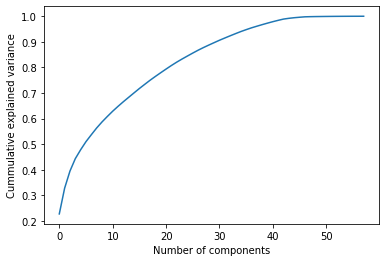

In [42]:
pca = PCA(n_components=None).fit(X_train_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cummulative explained variance')
plt.show()

In [42]:
X_train_pca = PCA(n_components=30).fit_transform(X_train_std)
X_val_pca = PCA(n_components=30).fit_transform(X_val_std)
X_test_pca = PCA(n_components=30).fit_transform(X_test_std)

### Regression

In [ ]:
model_stats_df = pd.DataFrame(data=None, index=["linear_regression", "random_forest", "svm"], columns=["mse", "mae", "r2"])

##### Helper functions

In [45]:
def model_evaluation(y, y_predicted, N, d):
    mse = mean_squared_error(y, y_predicted) # np.mean((y_test-y_predicted)**2)
    mae = mean_absolute_error(y, y_predicted) # np.mean(np.abs(y_test-y_predicted))
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_predicted)
    r2_adj = 1-(1-r2)*(N-1)/(N-d-1)
    rss = mse * N

    # printing values
    print('Mean squared error: ', mse)
    print('Mean absolute error: ', mae)
    print('Root mean squared error: ', rmse)
    print('R2 score: ', r2)
    print('R2 adjusted score: ', r2_adj)
    
    # Uporedni prikaz nekoliko pravih i predvidjenih vrednosti
    res=pd.concat([pd.DataFrame(y.values), pd.DataFrame(y_predicted)], axis=1)
    res.columns = ['y', 'y_pred']
    print(res.head(20))

In [46]:
def model_metrics(y, y_predicted):
    # N, d = shape
    mse = mean_squared_error(y, y_predicted) # np.mean((y_test-y_predicted)**2)
    mae = mean_absolute_error(y, y_predicted) # np.mean(np.abs(y_test-y_predicted))
    # rmse = np.sqrt(mse)
    r2 = r2_score(y, y_predicted)
    # r2_adj = 1-(1-r2)*(N-1)/(N-d-1)
    # rss = mse * N
    return mse, mae, r2

#### Attempt \#1: Linear Regression Model

We've distributed 80% of all our data into training set, 10% into validation and remaining 10% into test sets. Using Linear Regression model (even though data is nowhere near normally distributed) we'll conduct a quick research to check how our model performs with the given features. Furthermore, applying various data manipulation methods such as feature selection, dimension reduction etc. we'll remove some of the features and see how our model performs. For measuring our models performance we'll be using MSE, MAE, RMSE, R2, R2 adj.

After removing several features using feature selection via backpropagation our model doesn't perform any better, however, in order to compare models we should use a measurment such as F-statistic (TODO).

##### Training

Mean squared error:  0.6420499191620466
Mean absolute error:  0.5121011861049579
Root mean squared error:  0.8012801751959464
R2 score:  0.854407959979609
R2 adjusted score:  0.8541060853747693
       y    y_pred
0   2.00  1.379178
1   0.00  0.519522
2   4.04  4.766649
3   0.00 -0.127425
4   0.00  0.199968
5   0.71  1.462427
6   0.00  0.032497
7   0.00 -0.132165
8   2.00  1.500852
9   0.00  0.305939
10  5.25  3.046195
11  6.00  6.453850
12  0.06  0.928926
13  0.00  0.947300
14  6.63  5.857003
15  0.00  0.294042
16  5.67  5.228903
17  7.67  6.833919
18  6.86  5.003119
19  0.00  0.300255


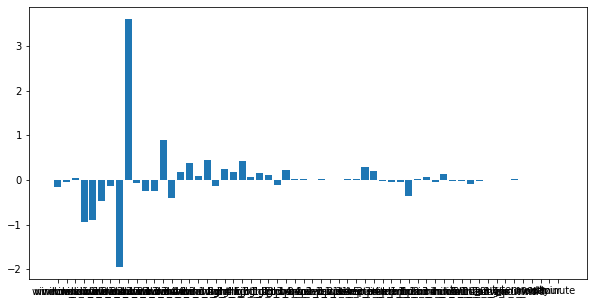

koeficijenti:  [-1.64875168e-01 -5.65841161e-02  3.52364441e-02 -9.32289551e-01
 -8.97449353e-01 -4.67723161e-01 -1.47364560e-01 -1.94160062e+00
  3.59652988e+00 -7.09184393e-02 -2.49308412e-01 -2.48383094e-01
  8.88620242e-01 -3.97101816e-01  1.74633094e-01  3.74062304e-01
  9.80478974e-02  4.52672160e-01 -1.26938032e-01  2.54790397e-01
  1.68272959e-01  4.26670651e-01  6.25832474e-02  1.65439488e-01
  1.01212539e-01 -1.18877531e-01  2.19460919e-01  1.09978755e-02
  1.30173069e-02  4.45282497e-03  1.00345191e-02  5.69061187e-03
  3.05386875e-03  2.32234271e-02  1.28587257e-02  2.93461410e-01
  1.94491685e-01 -2.85032380e-02 -4.90181965e-02 -5.17854872e-02
 -3.60050825e-01  2.25219089e-02  6.38631673e-02 -3.97248476e-02
  1.32806901e-01 -2.47729342e-02 -2.28701054e-02 -8.85900232e-02
 -1.70302923e-02  5.79040440e-04 -7.52888857e-04  1.06098984e-04
  1.42944284e-02  5.21069182e-04  2.86618383e-04  4.53794920e-03
  5.52761006e-04 -2.12657556e-04]


In [44]:
model = LinearRegression(fit_intercept=True)

model.fit(X_train, y_train)

y_predicted = model.predict(X_val)

model_evaluation(y_val, y_predicted, X_train.shape[0], X_train.shape[1])
# rss_model = rss(y_val, y_predicted, X_train.shape[0])

plt.figure(figsize=(10,5))
plt.bar(X.columns, model.coef_)
plt.show()
print("koeficijenti: ", model.coef_)

##### Feature selection process

The following iteration selects all the features with highest P value that are greater than 0.05. For proper testing purposes, should've made an extra iteration which would increase/decrease the P value threshold and compare the model performance. However, with the current example and dataset, it shouldn't have made any difference.

In [244]:
X_sel = sm.add_constant(X_train)

model_sel = sm.OLS(y_train, X_sel.astype('float')).fit()
model_sel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       presence_overall   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     2935.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:11:45   Log-Likelihood:                -33368.
No. Observations:               28032   AIC:                         6.686e+04
Df Residuals:                   27972   BIC:                         6.735e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.8647      0.321     -5.808      0.000      -2.494      -1.235
window_ki           -0.1680      0.036     -4.628      0.000      -0.239      -0.097
window_o1_1         -0.0554      0.059     -0.942      0.346      -0.171       0.060
window_o1_2          0.0292      0.033      0.893      0.372      -0.035       0.093
window_o1_3         -0.9289      0.034    -27.295      0.000      -0.996      -0.862
window_o1_4         -0.8964      0.031    -29.235      0.000      -0.957      -0.836
window_o2_1         -0.4727      0.079     -5.986      0.000      -0.627      -0.318
window_o2_2         -0.1488      0.036     -4.077      0.000      -0.220      -0.077
window_o3_1         -1.9464      1.586     -1.228      0.220      -5.054       1.161
window_o3_2          3.5936      1.572      2.286      0.022       0.512       6.675
window_o3_3         -0.0692      0.066     -1.050      0.294      -0.198       0.060
window_o3_4         -0.2522      0.033     -7.663      0.000      -0.317      -0.188
window_o4_1         -0.2412      0.024    -10.227      0.000      -0.287      -0.195
window_o4_2          0.8768      0.073     12.028      0.000       0.734       1.020
window_mr_1         -0.3982      0.047     -8.409      0.000      -0.491      -0.305
window_mr_2          0.1699      0.047      3.593      0.000       0.077       0.263
window_mr_3          0.3773      0.103      3.677      0.000       0.176       0.578
window_mr_4          0.1004      0.027      3.725      0.000       0.048       0.153
window_mr_5          0.4522      0.086      5.231      0.000       0.283       0.622
window_mr_6         -0.1305      0.058     -2.253      0.024      -0.244      -0.017
light_ki             0.2580      0.065      3.940      0.000       0.130       0.386
light_o1_1           0.1688      0.047      3.581      0.000       0.076       0.261
light_o1_2           0.4217      0.096      4.385      0.000       0.233       0.610
light_o2             0.0629      0.094      0.669      0.504      -0.121       0.247
light_o3_1           0.1661      0.076      2.172      0.030       0.016       0.316
light_o3_2           0.0998      0.081      1.225      0.221      -0.060       0.259
light_o4_1          -0.1233      0.187     -0.660      0.509      -0.490       0.243
light_o4_2           0.2144      0.116      1.853      0.064      -0.012       0.441
power_o1_1           0.0110      0.000     39.807      0.000       0.010       0.012
power_o1_2           0.0130      0.000     66.250      0.000       0.013       0.013
power_o1_3           0.0045      0.000     22.739      0.000       0.004       0.005
power_o1_4           0.0101      0.000     67.524      0.000       0.010       0.010
power_o1_5           0.0057   7.51e-05     76.136      0.000       0.006       0.006
power_o2             0.

In [245]:
X_sel = sm.add_constant(X_train)

model_sel = sm.OLS(y_train, X_sel.astype('float')).fit()
highest_pval = max(model_sel.pvalues)

feature_selected = []
while True:
    found = False
    if highest_pval < 0.05:
        break
    for feature in X_sel.columns.tolist():
        if model_sel.pvalues[feature] == highest_pval:
            feature_selected.append(feature)
            found = True
            break
    
    if not found:
        print("not found")
        break
    X_sel = sm.add_constant(X_train.drop(feature_selected, axis=1))

    model_sel = sm.OLS(y_train, X_sel.astype('float')).fit()

    highest_pval = max(model_sel.pvalues)

In [246]:
feature_selected

['humi_out_rh',
 'temp_out_tempout',
 'hour',
 'light_o4_1',
 'light_o2',
 'minute',
 'window_o1_2',
 'window_o1_1',
 'temp_in_o1_2',
 'window_o3_3',
 'window_o3_1',
 'light_o3_2',
 'month',
 'light_o4_2']

Mean squared error:  0.6434618844878716
Mean absolute error:  0.5132705326667321
Root mean squared error:  0.8021607597532252
R2 score:  0.854087780962231
R2 adjusted score:  0.8538531618720895
       y    y_pred
0   2.00  1.362110
1   0.00  0.521243
2   4.04  4.740348
3   0.00 -0.154890
4   0.00  0.203234
5   0.71  1.453638
6   0.00  0.044951
7   0.00 -0.125346
8   2.00  1.495797
9   0.00  0.315343
10  5.25  3.095695
11  6.00  6.452312
12  0.06  0.939568
13  0.00  0.931256
14  6.63  5.864780
15  0.00  0.293901
16  5.67  5.250155
17  7.67  6.777699
18  6.86  4.998801
19  0.00  0.296933


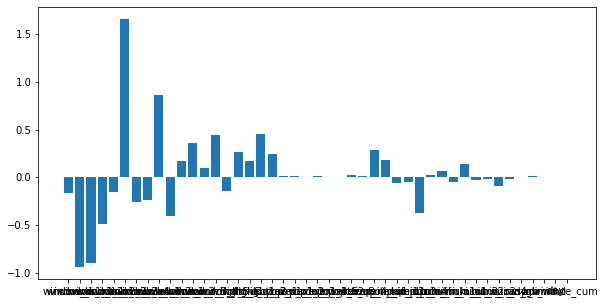

koeficijenti:  [-1.64250035e-01 -9.31824008e-01 -8.95466139e-01 -4.91329183e-01
 -1.51260143e-01  1.65056530e+00 -2.60735629e-01 -2.40758796e-01
  8.58665220e-01 -4.06275990e-01  1.73938962e-01  3.56580287e-01
  1.02767840e-01  4.39421707e-01 -1.43199792e-01  2.69850103e-01
  1.69844343e-01  4.54448688e-01  2.47773293e-01  1.10002062e-02
  1.29424614e-02  4.52904492e-03  1.00828038e-02  5.72628847e-03
  3.03379997e-03  2.32045557e-02  1.29261913e-02  2.83637356e-01
  1.80469340e-01 -5.48354514e-02 -5.17707382e-02 -3.69023986e-01
  2.86834096e-02  6.50142518e-02 -4.82174639e-02  1.38451069e-01
 -2.66313436e-02 -2.10107305e-02 -8.62945185e-02 -1.66333591e-02
  5.54464790e-04  1.42121609e-02  5.11110520e-04  4.94136321e-03
 -1.17736320e-07]


In [247]:
model_2 = LinearRegression(fit_intercept=True)

model_2.fit(X_train.drop(feature_selected, axis=1), y_train)

y_predicted = model_2.predict(X_val.drop(feature_selected, axis=1))

model_evaluation(y_val, y_predicted, X_train.shape[0], X_train.drop(feature_selected, axis=1).shape[1])
# rss_model_2 = rss(y_val, y_predicted, X_train.shape[0])

plt.figure(figsize=(10,5))
plt.bar(X.drop(feature_selected, axis=1).columns, model_2.coef_)
plt.show()
print("koeficijenti: ", model_2.coef_)

In [248]:
def todo_check_plot():
    def select_features(X_train, y_train, X_test):
        fs = SelectKBest(score_func=f_regression, k='all')
        fs.fit(X_train, y_train)
        X_train_fs = fs.transform(X_train)
        X_test_fs = fs.transform(X_test)
        return X_train_fs, X_test_fs, fs

    X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

    feat = []
    for i in range(len(fs.scores_)):
        # print('%s: %f' % (fs.feature_names_in_[i], fs.scores_[i]))
        feat.append((fs.feature_names_in_[i], fs.scores_[i]))

    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.show()

    sorted(feat, key=itemgetter(1), reverse=True)

##### Predict on test set

Mean squared error:  0.7230765543733978
Mean absolute error:  0.5271695633675034
Root mean squared error:  0.8503390819981155
R2 score:  0.8385459504157737
R2 adjusted score:  0.8357800419008291
       y    y_pred
0   0.00  0.373008
1   0.00 -0.246347
2   4.49  4.132016
3   0.00  0.215397
4   0.00  0.258110
5   0.40  0.562717
6   0.00  0.037794
7   0.00  0.245234
8   0.00  0.148620
9   4.57  4.055444
10  4.51  5.681945
11  0.92  1.342309
12  0.00  0.274163
13  0.00  0.323712
14  5.00  5.985597
15  2.00  1.371051
16  6.99  5.957648
17  0.00 -0.193002
18  5.35  5.976118
19  0.00 -0.025856


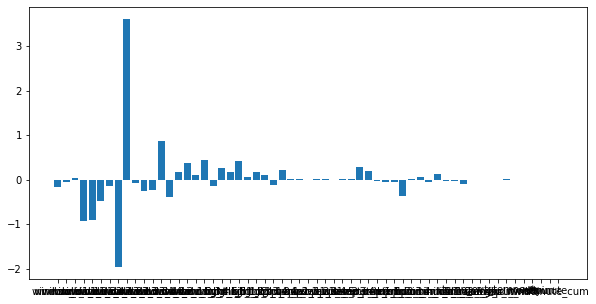

koeficijenti:  [-1.68033008e-01 -5.53678355e-02  2.92240987e-02 -9.28852538e-01
 -8.96442586e-01 -4.72652647e-01 -1.48782844e-01 -1.94642696e+00
  3.59362083e+00 -6.91841122e-02 -2.52222535e-01 -2.41210621e-01
  8.76796899e-01 -3.98233288e-01  1.69889774e-01  3.77331352e-01
  1.00367370e-01  4.52229366e-01 -1.30527403e-01  2.57986121e-01
  1.68757113e-01  4.21692947e-01  6.29245877e-02  1.66054843e-01
  9.98044007e-02 -1.23315904e-01  2.14389503e-01  1.09791055e-02
  1.29671896e-02  4.49483485e-03  1.00826514e-02  5.71951465e-03
  3.02584887e-03  2.31650817e-02  1.29058740e-02  2.93599149e-01
  1.92642425e-01 -2.52510345e-02 -4.91306521e-02 -5.28788663e-02
 -3.66159226e-01  2.66233316e-02  6.40883814e-02 -4.43884847e-02
  1.34549718e-01 -2.53601607e-02 -2.10896538e-02 -8.63401155e-02
 -1.67750911e-02  5.75341922e-04 -5.79954356e-04  1.30020315e-04
  1.43929818e-02  5.10744719e-04  2.76518183e-03  5.04671108e-03
  4.84308767e-04 -2.12287132e-04 -1.46088044e-07]


In [251]:
y_predicted = model.predict(X_test)

model_evaluation(y_test, y_predicted, X_test.shape[0], X_test.shape[1])

plt.figure(figsize=(10,5))
plt.bar(X.columns, model.coef_)
plt.show()
print("koeficijenti: ", model.coef_)

##### PCA

In [ ]:
model_pca = LinearRegression(fit_intercept=True)

model_pca.fit(X_train_pca, y_train)

y_predicted_pca = model_pca.predict(X_val_pca)

model_evaluation(y_val, y_predicted_pca, X_train_pca.shape[0], X_train_pca.shape[1])
# rss_model = rss(y_val, y_predicted, X_train.shape[0])

print("koeficijenti: ", model_pca.coef_)

In [250]:
y_predicted = model_pca.predict(X_test_pca)

model_evaluation(y_test, y_predicted_pca, X_test_pca.shape[0], X_test_pca.shape[1])

print("koeficijenti: ", model_pca.coef_)

Mean squared error:  8.067791021209791
Mean absolute error:  2.016693895199747
Root mean squared error:  2.840385716977501
R2 score:  -0.8014379303203463
R2 adjusted score:  -0.8169988683881868
       y    y_pred
0   0.00  0.407183
1   0.00  0.913210
2   4.49  6.938763
3   0.00 -0.788224
4   0.00 -0.369422
5   0.40  2.423791
6   0.00 -0.126838
7   0.00  0.324266
8   0.00  1.244918
9   4.57  0.310596
10  4.51  1.942696
11  0.92  5.362446
12  0.00  2.406969
13  0.00  0.177607
14  5.00  6.599066
15  2.00 -0.018038
16  6.99  3.456843
17  0.00  6.871690
18  5.35  6.898084
19  0.00  0.121765
koeficijenti:  [ 1.54070869e-01  5.02457584e-01 -5.34146976e-01 -4.92108750e-01
  4.81001594e-02 -4.16423352e-02  4.68685834e-02  1.69721352e-01
 -1.81488639e-01 -4.49907204e-02  4.79216322e-02 -2.13525169e-02
 -8.53194118e-03 -4.11270774e-02 -7.09552090e-02 -2.04909845e-02
  2.56681509e-02  3.69863142e-02  4.46463288e-02 -2.78833232e-02
  1.95126863e-02 -1.11650091e-01  2.13830575e-01  6.40592148e-02
  

##### Standardized Features

Mean squared error:  0.6420499191620449
Mean absolute error:  0.5121011861049545
Root mean squared error:  0.8012801751959454
R2 score:  0.8544079599796094
R2 adjusted score:  0.8541060853747696
       y    y_pred
0   2.00  1.379178
1   0.00  0.519522
2   4.04  4.766649
3   0.00 -0.127425
4   0.00  0.199968
5   0.71  1.462427
6   0.00  0.032497
7   0.00 -0.132165
8   2.00  1.500852
9   0.00  0.305939
10  5.25  3.046195
11  6.00  6.453850
12  0.06  0.928926
13  0.00  0.947300
14  6.63  5.857003
15  0.00  0.294042
16  5.67  5.228903
17  7.67  6.833919
18  6.86  5.003119
19  0.00  0.300255


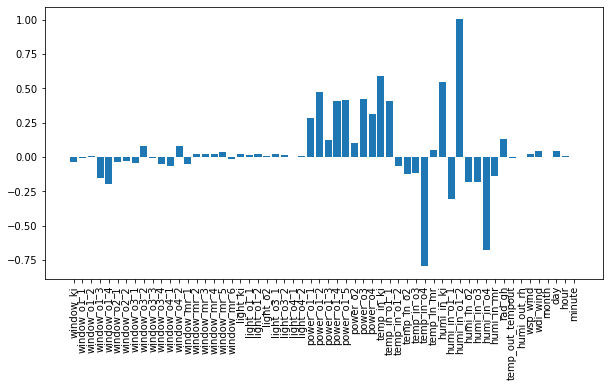

koeficijenti:  [-3.47110874e-02 -5.81088213e-03  6.53843285e-03 -1.50106545e-01
 -1.95302930e-01 -4.01676235e-02 -2.80251865e-02 -4.18083501e-02
  7.83937664e-02 -7.80887845e-03 -4.89714563e-02 -6.85033604e-02
  7.95081740e-02 -5.41329935e-02  2.04636180e-02  1.96807649e-02
  2.36194705e-02  3.24347829e-02 -1.64704338e-02  1.88330274e-02
  1.75975973e-02  2.18931169e-02  3.18952681e-03  1.83703677e-02
  1.05168228e-02 -3.32899841e-03  1.01423944e-02  2.85770491e-01
  4.70974243e-01  1.19708792e-01  4.10219288e-01  4.11556229e-01
  1.00369133e-01  4.22859695e-01  3.10919848e-01  5.86194651e-01
  4.10894208e-01 -6.28280973e-02 -1.23389407e-01 -1.16288234e-01
 -7.95782299e-01  5.22604537e-02  5.45610213e-01 -3.08932549e-01
  1.00376924e+00 -1.86182517e-01 -1.85096690e-01 -6.79426874e-01
 -1.39573751e-01  1.28733166e-01 -6.69908477e-03  1.78721533e-03
  2.31013440e-02  4.65966225e-02  9.87249448e-04  3.99077148e-02
  3.82263171e-03 -3.56683507e-03]


In [44]:
model_std = LinearRegression(fit_intercept=True)

model_std.fit(X_train_std, y_train)

y_predicted = model_std.predict(X_val_std)

model_evaluation(y_val, y_predicted, X_train_std.shape[0], X_train_std.shape[1])
# rss_model = rss(y_val, y_predicted, X_train.shape[0])

plt.figure(figsize=(10,5))
plt.bar(X_train_std.columns, model_std.coef_)
plt.xticks(rotation=90)
plt.show()
print("koeficijenti: ", model_std.coef_)

In [46]:
y_predicted = model_std.predict(X_test_std)

model_evaluation(y_test, y_predicted, X_test_std.shape[0], X_test_std.shape[1])

mse, mae, r2 = model_metrics(y_test, y_predicted)

model_stats_df.loc['linear_regression'] = [mse, mae, r2]

Mean squared error:  0.7225974684207729
Mean absolute error:  0.5270071615038671
Root mean squared error:  0.8500573324316266
R2 score:  0.838652924382337
R2 adjusted score:  0.8359364859539409
       y    y_pred
0   0.00  0.389405
1   0.00 -0.216820
2   4.49  4.135715
3   0.00  0.222416
4   0.00  0.235065
5   0.40  0.577913
6   0.00  0.067588
7   0.00  0.235504
8   0.00  0.140216
9   4.57  4.060883
10  4.51  5.683600
11  0.92  1.339028
12  0.00  0.267305
13  0.00  0.304858
14  5.00  5.963310
15  2.00  1.380131
16  6.99  5.952922
17  0.00 -0.157213
18  5.35  5.955863
19  0.00 -0.007428


##### Polynomial

TODO: Change the degree parameter to a value greater than 2. Computationally demanding task, couldn't run it on my machine (8GB RAM + 12GB Swap Mem. non-dyn.). After that, use Ridge/Lasso and see how model behaves through metrics.

In [46]:
poly = PolynomialFeatures(interaction_only=True, include_bias=True, degree=2)

X_train_inter = poly.fit_transform(X_train_std)
X_val_inter = poly.fit_transform(X_val_std)
X_test_inter = poly.fit_transform(X_test_std)

print(poly.get_feature_names_out())

['1' 'window_ki' 'window_o1_1' ... 'day hour' 'day minute' 'hour minute']


In [44]:
del df, X, X_train, X_val, X_test

In [47]:
# init
model_inter = LinearRegression()

# train
model_inter.fit(X_train_inter, y_train)

# predict
y_predicted = model_inter.predict(X_val_inter)

model_evaluation(y_val, y_predicted, X_train_inter.shape[0], X_train_inter.shape[1])

# plt.figure(figsize=(10,5))
# plt.bar(range(len(model_inter.coef_)),model_inter.coef_)
# plt.show()
# print("koeficijenti: ", model_inter.coef_)

Mean squared error:  1.5982784425136334e+21
Mean absolute error:  1357669835.359329
Root mean squared error:  39978474739.71004
R2 score:  -3.624276119680391e+20
R2 adjusted score:  -3.8600282651605697e+20
       y    y_pred
0   2.00  1.587587
1   0.00 -0.269505
2   4.04  5.060254
3   0.00 -0.055528
4   0.00 -0.176228
5   0.71  1.250535
6   0.00 -0.007015
7   0.00  0.039932
8   2.00  2.054444
9   0.00  0.099702
10  5.25  5.268780
11  6.00  6.377235
12  0.06  0.662186
13  0.00  0.607901
14  6.63  6.384735
15  0.00  0.329271
16  5.67  4.653717
17  7.67  6.436059
18  6.86  5.129323
19  0.00  0.195928


#### Attempt \#2: Support Vector Machines - SVR

In attempt #2 we're checking how well does SVM (Support Vector Machines) predict the presence value. Won't be going too in-depth with this model as compared to the previous one since this model takes a whole while to fit and predict on the machine I'm using right now to test it on. The model does outperform the previous one when it comes to metrics, however, since SVM has a time-complexity of O(n^2) it does take quite a bit to fit the data. <br>

I've tried training the model on data where we've applied dimension reductions using PCA, however, the metrics would only worsen up - further testings are required, to find the underlying issue (possibly the `presence_overall` feature [TODO: test on `presence_overall_mean`]).

In [47]:
from sklearn.svm import SVR

##### Training

In [107]:
model = SVR(kernel='rbf')

model.fit(X_train_std, y_train)

y_predicted = model.predict(X_val_std)

model_evaluation(y_val, y_predicted, X_train_std.shape[0], X_train_std.shape[1])


Mean squared error:  0.4554436703002515
Mean absolute error:  0.33931765633426886
Root mean squared error:  0.6748656683372266
R2 score:  0.8967230255866565
R2 adjusted score:  0.8965088882214839
       y    y_pred
0   2.00  1.882246
1   0.00 -0.132752
2   4.04  5.390659
3   0.00  0.035055
4   0.00 -0.083303
5   0.71  1.257021
6   0.00 -0.010042
7   0.00 -0.076389
8   2.00  1.993658
9   0.00 -0.022152
10  5.25  5.237468
11  6.00  5.934527
12  0.06  0.469660
13  0.00  0.151445
14  6.63  5.987270
15  0.00  0.021590
16  5.67  5.307795
17  7.67  6.363116
18  6.86  5.291492
19  0.00  0.026768


##### Searching for optimal parameters using GridSearchCV

Note: Takes a while to fit the model to the data using parameters that GridSearchCV finds optimal. However, the performance of model does go up even though the time it takes for training increases 10-20 times compared to before. (Higher the C value, longer it takes for model to fit to data)

In [ ]:
# C_range = np.logspace(-2, 10, 13)
# gamma_range = np.logspace(-9, 3, 13)

C_range = [1e-2, 1, 1e2]
gamma_range = [1e-1, 1, 1e1]
# kernel_pos = ['linear', 'poly', 'sigmoid']
kernel_pos = ['rbf']
cache_size = [1024]
param_grid = dict(kernel=kernel_pos, gamma=gamma_range, C=C_range, cache_size = cache_size)

cv = KFold(n_splits=2, shuffle=True, random_state=42)
grid = GridSearchCV(SVR(), param_grid, scoring='neg_mean_squared_error', cv=cv, verbose=3, n_jobs=-1)
grid.fit(X_train_std, y_train)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

In [48]:
model = SVR(kernel="rbf", C=100.0, gamma=0.1, epsilon=0.1, cache_size=1024)

model.fit(X_train_std, y_train)

y_predicted = model.predict(X_val_std)

model_evaluation(y_val, y_predicted, X_train_std.shape[0], X_train_std.shape[1])

Mean squared error:  0.4162666604780084
Mean absolute error:  0.3294697390139966
Root mean squared error:  0.6451873065071944
R2 score:  0.9056068531702866
R2 adjusted score:  0.9054111357815144
       y    y_pred
0   2.00  1.946498
1   0.00  0.046325
2   4.04  4.749598
3   0.00 -0.061821
4   0.00 -0.005066
5   0.71  1.047745
6   0.00 -0.028566
7   0.00 -0.014620
8   2.00  1.994633
9   0.00  0.092216
10  5.25  5.015329
11  6.00  5.938399
12  0.06  0.579142
13  0.00 -0.184193
14  6.63  7.004187
15  0.00  0.099793
16  5.67  5.318916
17  7.67  5.831404
18  6.86  5.788455
19  0.00  0.079965


##### Performance evaluation on test set

SVR does a solid job. Ideally we'd want the MSE and MAE to be lower, thought it could be that the `presence_overall` feature isn't a perfect representation of what we're trying to achieve. Further testing on each `pres_` feature could give an additional insight into the possible problem we're dealing with here.

In [49]:
y_predicted = model.predict(X_test_std)

model_evaluation(y_test, y_predicted, X_test_std.shape[0], X_test_std.shape[1])

mse, mae, r2 = model_metrics(y_test, y_predicted)

model_stats_df.loc["svm"] = [mse, mae, r2]

Mean squared error:  0.4444966437525321
Mean absolute error:  0.337768308483878
Root mean squared error:  0.6667058149982885
R2 score:  0.9007493982118752
R2 adjusted score:  0.8990784156563711
       y    y_pred
0   0.00  0.318074
1   0.00 -0.069004
2   4.49  4.225535
3   0.00 -0.026897
4   0.00  0.147895
5   0.40  2.192327
6   0.00 -0.047366
7   0.00  0.046405
8   0.00  0.054898
9   4.57  4.545495
10  4.51  5.010478
11  0.92  1.108935
12  0.00  0.042871
13  0.00 -0.113627
14  5.00  4.849879
15  2.00  1.904155
16  6.99  3.863690
17  0.00 -0.049628
18  5.35  5.774769
19  0.00 -0.035019


#### Attempt \#3: Random Forest Regressor

For third model I've selected Random Forest Regressor. Random forest works by defining a decision tree, where each node represents some sort of `decision` (condition) which then lets tree know which leaf/next node should it visit until it gets to the maximum depth of the created tree. During the training process, random forest works by creating a multitude of decision trees (just many different decision trees) where each one of them will compute a final value for some given input. At the end, the decision tree which is selected is the one that correlates or is similar(the same?) to most other ones as well.

Additionally, I've conducted a short experiment in this part as well, where I've calculated a mean for all the features that are "the same". So I've computed mean for features representing temperature in all of the available offices, mean for state of windows in each office, etc. Lo and behold it didn't do much, except for ruining the models performance...

`TODO`: ~~GridSearchCV~~

In [51]:
from sklearn.ensemble import RandomForestRegressor

##### Mean for similar/same features

In [177]:
ignore_features = ["day", "month", "year", "hour", "minute"]

def check_dict(key, value, same_dict):
    if key in same_dict:
        same_dict[key].append(value)
    else:
        same_dict[key] = [value]

def dict_init(X) -> dict:
    same_dict = {}
    for column in X.columns:
        splt = column.split("_")
        if splt[0] in ignore_features:
            continue
        if "in" in splt:
            key_name = splt[0] + "_in"
            check_dict(key_name, column, same_dict)
        elif "out" in splt:
            key_name = splt[0] + "_out"
            check_dict(key_name, column, same_dict)
        else:
            check_dict(splt[0], column, same_dict)
    
    return same_dict

def update_X(same_dict, X):
    for key, value in same_dict.items():
        X[key+"_mean"] = X.loc[:, value].mean(axis=1)
        X.drop(value, axis=1, inplace=True)
    
def agg_X(X):
    same_dict = dict_init(X)
    update_X(same_dict, X)
    return X
    

In [178]:
X_train_tree = agg_X(X_train.copy(deep=True))
X_val_tree = agg_X(X_val.copy(deep=True))
X_test_tree = agg_X(X_test.copy(deep=True))

In [164]:
X_train_tree.head()

,month,day,hour,minute,window_mean,light_mean,power_mean,temp_in_mean,humi_in_mean,rad_mean,temp_out_mean,humi_out_mean,wsp_mean,wdi_mean
9284,7,4,17,0,19.0,0,176.38,156.78,158.7,57.0,4.4,46.0,3.50,298.0
14314,5,30,2,30,19.0,0,104.66,152.40,246.2,1.0,11.3,84.0,3.61,270.0
5094,2,23,1,30,19.0,0,159.14,158.54,132.4,2.0,-1.9,97.0,1.38,251.0
33269,12,13,13,15,19.0,0,621.21,163.28,207.0,128.0,3.4,76.0,0.93,317.0
9994,4,15,2,30,19.0,0,107.02,157.18,179.4,0.0,9.8,51.0,0.22,214.0


##### Training

In [43]:
model = RandomForestRegressor(n_jobs=-1)

model.fit(X_train, y_train)

y_predicted = model.predict(X_val)

model_evaluation(y_val, y_predicted, X_train.shape[0], X_train.shape[1])

Mean squared error:  0.2924903186386987
Mean absolute error:  0.2458148687214612
Root mean squared error:  0.5408237408238461
R2 score:  0.933674530739915
R2 adjusted score:  0.9335370096582618
       y  y_pred
0   2.00  2.0000
1   0.00  0.0000
2   4.04  5.2274
3   0.00  0.0000
4   0.00  0.0000
5   0.71  1.1754
6   0.00  0.0000
7   0.00  0.0174
8   2.00  2.0000
9   0.00  0.0000
10  5.25  4.3661
11  6.00  6.0000
12  0.06  0.4623
13  0.00  0.0080
14  6.63  6.6656
15  0.00  0.0000
16  5.67  4.9325
17  7.67  6.5042
18  6.86  5.8572
19  0.00  0.0683


In [165]:
model = RandomForestRegressor(n_jobs=-1)

model.fit(X_train_tree, y_train)

y_predicted = model.predict(X_val_tree)

model_evaluation(y_val, y_predicted, X_train_tree.shape[0], X_train_tree.shape[1])

Mean squared error:  0.3210073958732876
Mean absolute error:  0.26235485159817346
Root mean squared error:  0.5665751458308841
R2 score:  0.9272079627580648
R2 adjusted score:  0.9271715888236184
       y  y_pred
0   2.00  2.0000
1   0.00  0.0000
2   4.04  5.0885
3   0.00  0.0000
4   0.00  0.0000
5   0.71  1.4643
6   0.00  0.0000
7   0.00  0.0139
8   2.00  2.0000
9   0.00  0.1586
10  5.25  4.8201
11  6.00  6.0000
12  0.06  0.7126
13  0.00  0.0000
14  6.63  6.5911
15  0.00  0.0000
16  5.67  5.2008
17  7.67  6.2701
18  6.86  5.3120
19  0.00  0.0000


In [221]:
model = RandomForestRegressor(n_jobs=-1)

model.fit(X_train_std, y_train)

y_predicted = model.predict(X_val_std)

model_evaluation(y_val, y_predicted, X_train_std.shape[0], X_train_std.shape[1])

Mean squared error:  0.2865927892437215
Mean absolute error:  0.2426746860730594
Root mean squared error:  0.5353436179163076
R2 score:  0.935011861857121
R2 adjusted score:  0.9348771136351826
       y  y_pred
0   2.00  2.0000
1   0.00  0.0000
2   4.04  5.3450
3   0.00  0.0000
4   0.00  0.0000
5   0.71  1.1826
6   0.00  0.0000
7   0.00  0.0135
8   2.00  2.0000
9   0.00  0.0000
10  5.25  4.3196
11  6.00  6.0000
12  0.06  0.4482
13  0.00  0.0080
14  6.63  6.7126
15  0.00  0.0000
16  5.67  5.0344
17  7.67  6.5630
18  6.86  5.9050
19  0.00  0.0994


In [182]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

##### Optimazing hyperparameters

In [219]:
n_estimators = list(range(20, 110, 20))
max_depth = list(range(40, 110, 40))
max_depth.append(None)
max_features = ["sqrt", "log2"]
min_samples_leaf = list(range(1, 11, 4))
min_samples_split = list(range(2, 11, 4))
bootstrap = [True]
n_jobs = [-1]

param_grid = dict(n_estimators      = n_estimators, 
                  max_depth         = max_depth,
                  max_features      = max_features,
                  min_samples_leaf  = min_samples_leaf,
                  min_samples_split = min_samples_split,
                  bootstrap         = bootstrap,
                  n_jobs            = n_jobs)

cv = KFold(n_splits=2, shuffle=True, random_state=42)
grid = GridSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=cv, verbose=3, n_jobs=-1)
grid.fit(X_train_std, y_train)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 2 folds for each of 270 candidates, totalling 540 fits


[CV 1/2] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20, n_jobs=-1;, score=-0.341 total time=   1.4s
[CV 2/2] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20, n_jobs=-1;, score=-0.325 total time=   1.8s
[CV 1/2] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, n_jobs=-1;, score=-0.331 total time=   2.4s
[CV 2/2] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, n_jobs=-1;, score=-0.308 total time=   4.0s
[CV 1/2] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60, n_jobs=-1;, score=-0.329 total time=   5.0s
[CV 2/2] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60, n_jobs=-1;, score=-0.300 total time=   4.3s
[CV 1/2] END boo

In [52]:
# The best parameters are {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80, 'n_jobs': -1} with a score of -0.31
# The best parameters are {'bootstrap': True, 'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} with a score of -0.31

model = RandomForestRegressor(n_estimators=100, max_features="sqrt", max_depth=80, bootstrap=True, min_samples_leaf=1, min_samples_split=2, n_jobs=-1)

model.fit(X_train_std, y_train)

y_predicted = model.predict(X_val_std)

model_evaluation(y_val, y_predicted, X_train_std.shape[0], X_train_std.shape[1])

Mean squared error:  0.2583522063613014
Mean absolute error:  0.2376005993150685
Root mean squared error:  0.5082835885224914
R2 score:  0.9414157316350078
R2 adjusted score:  0.9412942613756445
       y  y_pred
0   2.00  2.0000
1   0.00  0.0038
2   4.04  5.1797
3   0.00  0.0000
4   0.00  0.0000
5   0.71  1.3494
6   0.00  0.0013
7   0.00  0.0105
8   2.00  2.0000
9   0.00  0.0046
10  5.25  4.6365
11  6.00  6.0000
12  0.06  0.6935
13  0.00  0.0001
14  6.63  6.6481
15  0.00  0.0000
16  5.67  5.0241
17  7.67  6.5896
18  6.86  5.6309
19  0.00  0.0722


##### Performance evaluation on test set

In [53]:
y_predicted = model.predict(X_test_std)

model_evaluation(y_test, y_predicted, X_test_std.shape[0], X_test_std.shape[1])

mse, mae, r2 = model_metrics(y_test, y_predicted)

model_stats_df.loc["random_forest"] = [mse, mae, r2]

Mean squared error:  0.2507108072517124
Mean absolute error:  0.23478473173515982
Root mean squared error:  0.5007103027217559
R2 score:  0.944019378224209
R2 adjusted score:  0.9430768888009882
       y  y_pred
0   0.00  0.0408
1   0.00  0.0139
2   4.49  4.5663
3   0.00  0.0000
4   0.00  0.0000
5   0.40  1.1263
6   0.00  0.0476
7   0.00  0.0984
8   0.00  0.0000
9   4.57  5.0022
10  4.51  5.2294
11  0.92  1.4378
12  0.00  0.0000
13  0.00  0.0632
14  5.00  4.4621
15  2.00  2.0000
16  6.99  5.6091
17  0.00  0.0000
18  5.35  5.5655
19  0.00  0.0000


#### Model comparison

In [54]:
model_stats_df.head()

,mse,mae,r2
linear_regression,0.722597,0.527007,0.838653
random_forest,0.250711,0.234785,0.944019
svm,0.444497,0.337768,0.900749


AxesSubplot(0.125,0.125;0.775x0.755)


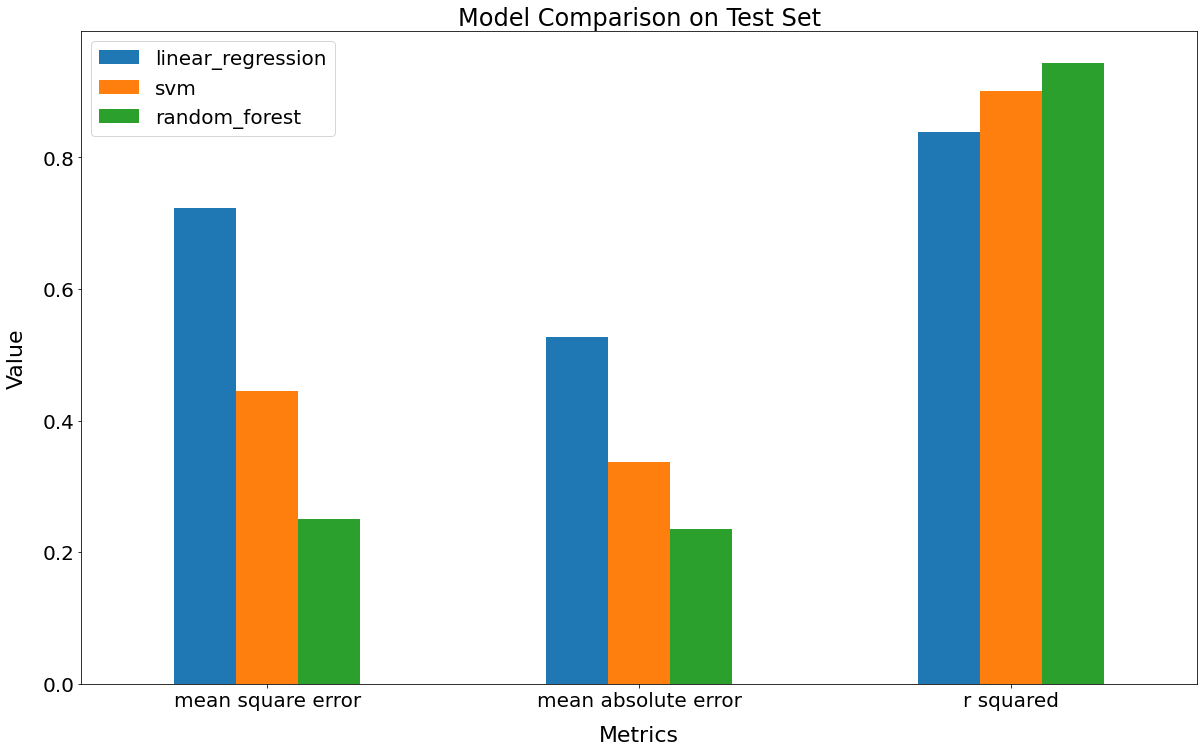

In [117]:
plt.rcParams.update({'font.size': 20})
cm = model_stats_df.sort_values(by=['mse', 'mae', 'r2'], ascending=False).T.plot(kind="bar", figsize=(20, 12))
print(cm)
# plt.bar_label(container=cm.containers[0], labels=['linear', 'linear', 'linear'])
plt.title("Model Comparison on Test Set")
plt.xlabel("Metrics", labelpad=15, size=22)
plt.ylabel("Value", labelpad=15, size=22)
plt.xticks(rotation=0)
cm.set_xticklabels(['mean square error', 'mean absolute error', 'r squared'])
plt.show()

### Classification

In [44]:
# TODO: add dataframe to track stats for all the models used in classification
# model_stats_df = pd.DataFrame(data=None, index=["linear_regression", "random_forest", "svm"], columns=["mse", "mae", "r2"])

##### Helper Functions

In [38]:
def evaluation_classifier(y_pred, y_test):
    
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Precision [micro]: ", precision_score(y_test, y_pred, average='micro'))
    print("Precision [macro]: ", precision_score(y_test, y_pred, average='macro'))
    print("Sensitivity [micro]: ", recall_score(y_test, y_pred, average='micro'))
    print("Sensitivity [macro]: ", recall_score(y_test, y_pred, average='macro'))
    print("F score [micro]: ", f1_score(y_test, y_pred, average='micro'))
    print("F score [macro]: ", f1_score(y_test, y_pred, average='macro'))

    print("Precision [all]: ", precision_score(y_test, y_pred, average=None))
    print("F score [all]: ", f1_score(y_test, y_pred, average=None))
    print("Sensitivity [all]: ", recall_score(y_test, y_pred, average=None))

In [39]:
def plot_confusion_matrix(c, model):
    disp = ConfusionMatrixDisplay(c, display_labels=model.classes_)
    _, ax = plt.subplots(figsize=(5, 5))
    disp.plot(cmap="Blues", xticks_rotation=45, ax=ax)

##### Data distribution for classification

In [40]:
X = df.iloc[:, 9:-5].copy()
y = df.iloc[:, -1].copy()

In [41]:
# class distribution
y.value_counts()

absent       20519
very low      4303
low           4047
high          2699
moderate      2511
very high      961
Name: class, dtype: int64

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)

In [141]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X.columns)
X_val_std = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X.columns)

##### Binary classification

In [40]:
df_binary = df.copy()

In [41]:
df['class'] = df['class'].apply(lambda x: x if x == 'absent' else 'present')

In [42]:
X = df.iloc[:, 9:-5].copy()
y = df.iloc[:, -1].copy()

In [43]:
y.value_counts()

absent     20519
present    14521
Name: class, dtype: int64

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)

##### Resample test

In [41]:
from sklearn.utils import resample

In [42]:
df_resampled = df.copy(deep=True)

In [43]:
df_majority = df_resampled.loc[df_resampled['class'] == 'absent', :]
df_resampled.drop(df_resampled.loc[df_resampled['class'] == 'absent', :].index, inplace=True)

In [44]:
max_len = max(df_resampled['class'].value_counts())

In [45]:
df_majority.shape

(20519, 73)

In [46]:
# downsample 'absent' class
df_majority = resample(df_majority, replace=True, n_samples=max_len, random_state=42)

df_majority.shape

(4303, 73)

In [47]:
df_resampled = pd.concat([df_resampled, df_majority])

In [48]:
df_resampled['class'].value_counts()

absent       4303
very low     4303
low          4047
high         2699
moderate     2511
very high     961
Name: class, dtype: int64

In [54]:
df_minority = df_resampled.loc[df_resampled['class'] == 'very high', :]

df_minority = resample(df_minority, replace=True, n_samples=max_len, random_state=42)

df_minority.shape

(4303, 73)

In [55]:
df_resampled = df_resampled.loc[df_resampled['class'] != 'very high', :]

In [56]:
df_resampled = pd.concat([df_resampled, df_minority])

In [57]:
df_resampled['class'].value_counts()

absent       4303
very low     4303
very high    4303
low          4047
high         2699
moderate     2511
Name: class, dtype: int64

In [58]:
X = df_resampled.iloc[:, 9:-5].copy()
y = df_resampled.iloc[:, -1].copy()

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)

#### Attempt 1: KNN

##### Training

In [43]:
y_val.value_counts()

absent       2052
very low      431
low           404
high          270
moderate      251
very high      96
Name: class, dtype: int64

[[2026    0    9    0    0   17]
 [   1  187   14   54   12    2]
 [  30   24  253   40    4   53]
 [   5   67   62  100    6   11]
 [   0   51    1    7   35    2]
 [ 118    5   40   12    0  256]]
Accuracy:  0.8153538812785388
Precision [micro]:  0.8153538812785388
Precision [macro]:  0.6105194793815903
Sensitivity [micro]:  0.8153538812785388
Sensitivity [macro]:  0.665172667575484
F score [micro]:  0.8153538812785388
F score [macro]:  0.6291113189874585
Precision [all]:  [0.98732943 0.69259259 0.62623762 0.39840637 0.36458333 0.59396752]
F score [all]:  [0.95746692 0.6192053  0.64623244 0.43103448 0.45751634 0.66321244]
Sensitivity [all]:  [0.9293578  0.55988024 0.66754617 0.46948357 0.61403509 0.75073314]


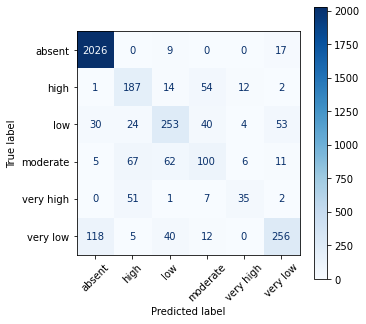

In [44]:
knn_model = KNeighborsClassifier(n_jobs=-1)

knn_model.fit(X_train, y_train)

y_predicted = knn_model.predict(X_val)

c = confusion_matrix(y_val, y_predicted)
print(c)
evaluation_classifier(y_val, y_predicted)
plot_confusion_matrix(c, knn_model)

In [45]:
y_train.unique()

['absent', 'very low', 'low', 'very high', 'high', 'moderate']
Categories (6, object): ['absent' < 'very low' < 'low' < 'moderate' < 'high' < 'very high']

In [146]:
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

n_neighbors = list(range(1, 10, 2))
# algorithm = ['auto', 'kd_tree']
# leaf_size = list(range(10, 51, 20))
p = list(range(2, 11, 4))
metric = ['euclidean', 'manhattan', 'chebyshev']
n_jobs = [-1]

param_grid = dict(
    n_neighbors = n_neighbors,
    # algorithm = algorithm,
    # leaf_size = leaf_size,
    p = p,
    metric = metric,
    n_jobs = n_jobs
)

grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, n_jobs=-1, cv=cv, verbose=3, scoring='accuracy', refit=True)
grid.fit(X_train, y_train)

print(grid.best_score_)
print(grid.best_params_)

Fitting 2 folds for each of 45 candidates, totalling 90 fits


[CV 1/2] END metric=euclidean, n_jobs=-1, n_neighbors=1, p=6;, score=0.945 total time=   4.3s
[CV 2/2] END metric=euclidean, n_jobs=-1, n_neighbors=1, p=6;, score=0.945 total time=   4.5s
[CV 1/2] END metric=euclidean, n_jobs=-1, n_neighbors=1, p=2;, score=0.945 total time=   5.6s
[CV 2/2] END metric=euclidean, n_jobs=-1, n_neighbors=1, p=2;, score=0.945 total time=   5.6s
[CV 2/2] END metric=euclidean, n_jobs=-1, n_neighbors=1, p=10;, score=0.945 total time=   4.7s
[CV 1/2] END metric=euclidean, n_jobs=-1, n_neighbors=1, p=10;, score=0.945 total time=   4.7s
[CV 1/2] END metric=euclidean, n_jobs=-1, n_neighbors=3, p=2;, score=0.946 total time=   5.2s
[CV 2/2] END metric=euclidean, n_jobs=-1, n_neighbors=3, p=2;, score=0.947 total time=   5.5s
[CV 1/2] END metric=euclidean, n_jobs=-1, n_neighbors=3, p=6;, score=0.946 total time=   5.1s
[CV 2/2] END metric=euclidean, n_jobs=-1, n_neighbors=3, p=6;, score=0.947 total time=   5.4s
[CV 1/2] END metric=euclidean, n_jobs=-1, n_neighbors=3, p

[[400   0   0   1   0  29]
 [  0 167   5  54  43   1]
 [  5  20 265  58   2  55]
 [  0  51  55 131   6   8]
 [  0   3   0   0 428   0]
 [ 43   1  51   6   0 329]]
Accuracy:  0.7758231844835363
Precision [micro]:  0.7758231844835363
Precision [macro]:  0.7471900228558673
Sensitivity [micro]:  0.7758231844835363
Sensitivity [macro]:  0.747479343054073
F score [micro]:  0.7758231844835364
F score [macro]:  0.746339423442827
Precision [all]:  [0.93023256 0.61851852 0.65432099 0.52191235 0.99303944 0.76511628]
F score [all]:  [0.91116173 0.65234375 0.67861716 0.52295409 0.94065934 0.77230047]
Sensitivity [all]:  [0.89285714 0.69008264 0.70478723 0.524      0.89352818 0.77962085]


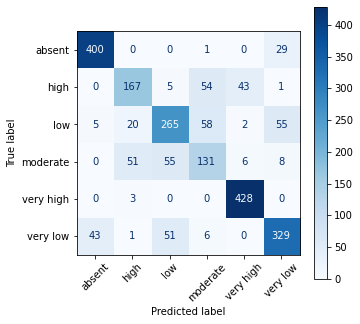

In [128]:
knn_model = KNeighborsClassifier(n_jobs=-1, metric='manhattan', n_neighbors=1, p=2)

knn_model.fit(X_train, y_train)

y_predicted = knn_model.predict(X_val)

c = confusion_matrix(y_val, y_predicted)
print(c)
evaluation_classifier(y_val, y_predicted)
plot_confusion_matrix(c, knn_model)

[[400   0   1   0   0  30]
 [  0 155  17  54  44   0]
 [  7  14 277  51   0  55]
 [  1  49  57 130   8   6]
 [  0   2   0   0 428   0]
 [ 36   2  57   1   1 334]]
Accuracy:  0.7776274244474515
Precision [micro]:  0.7776274244474515
Precision [macro]:  0.7460018339652842
Sensitivity [micro]:  0.7776274244474515
Sensitivity [macro]:  0.7504839021953692
F score [micro]:  0.7776274244474515
F score [macro]:  0.7466125580645736
Precision [all]:  [0.92807425 0.57407407 0.68564356 0.51792829 0.99534884 0.774942  ]
F score [all]:  [0.91428571 0.6300813  0.68142681 0.5338809  0.93962678 0.78037383]
Sensitivity [all]:  [0.9009009  0.6981982  0.67726161 0.55084746 0.88981289 0.78588235]


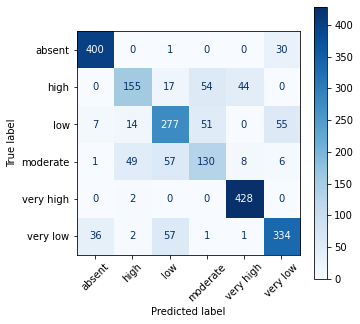

In [129]:
y_predicted = knn_model.predict(X_test)

c = confusion_matrix(y_test, y_predicted)
print(c)
evaluation_classifier(y_test, y_predicted)
plot_confusion_matrix(c, knn_model)

#### Attempt 2: Neural Network

In [45]:
from sklearn.neural_network import MLPClassifier

##### Training

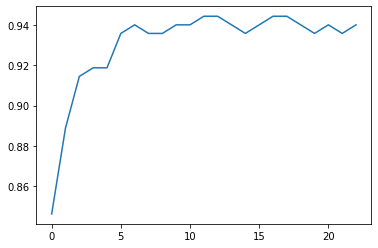

0.9486301369863014


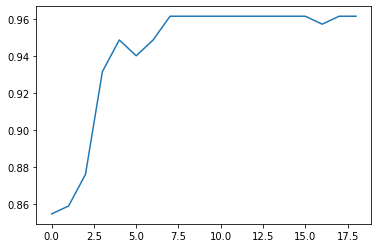

0.9434931506849316


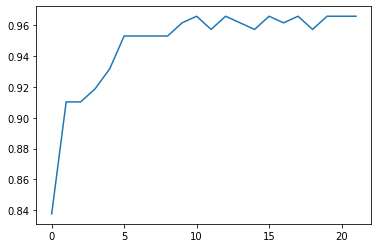

0.950513698630137


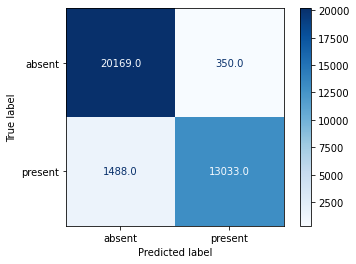

% correct predicted:  0.9475456621004567


In [65]:
s_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
indexes = s_kfold.split(X, y)
accuracy = []
final_confusion_matrix = np.zeros((len(np.unique(y)), len(np.unique(y))))

for train_index, test_index in indexes:
    classifier = MLPClassifier(hidden_layer_sizes=(64, 64, 64), activation='tanh',
                               solver='adam', batch_size=50, learning_rate='constant',
                               learning_rate_init=0.0001, max_iter=50, shuffle=True,
                               random_state=42, early_stopping=True, n_iter_no_change=10,
                               validation_fraction=.01, verbose=False)
    classifier.fit(X.iloc[train_index, :].values, y.iloc[train_index])
    y_predicted = classifier.predict(X.iloc[test_index, :].values)
    plt.figure
    plt.plot(classifier.validation_scores_)
    plt.show()
    print(accuracy_score(y.iloc[test_index], y_predicted))
    final_confusion_matrix += confusion_matrix(y.iloc[test_index], y_predicted)

conf_mat_display = ConfusionMatrixDisplay(confusion_matrix=final_confusion_matrix, display_labels=classifier.classes_)
conf_mat_display.plot(cmap='Blues', values_format='')
plt.show()

print("% correct predicted: ", sum(np.diag(final_confusion_matrix))/ sum(sum(final_confusion_matrix)))



##### Optimizing hyperparameters

In [46]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

hidden_layer_sizes = [(64, 64, 64), (32, 32, 32)]
activation = ['relu', 'tanh']
solver = ['adam']
batch_size = [50, 80]
learning_rate = ['constant', 'adaptive']
learning_rate_init = [0.001, 0.0005, 0.00001]
early_stopping = [True]
shuffle = [True]
max_iter = [50]
n_iter_no_change= [10]
validation_fraction = [0.1]
random_state = [42]

param_grid = dict(hidden_layer_sizes = hidden_layer_sizes,
                  activation = activation,
                  solver = solver,
                  batch_size = batch_size,
                  learning_rate = learning_rate,
                  learning_rate_init = learning_rate_init,
                  early_stopping = early_stopping,
                  shuffle = shuffle,
                  max_iter = max_iter,
                  n_iter_no_change = n_iter_no_change,
                  validation_fraction = validation_fraction,
                  random_state = random_state)


grid = GridSearchCV(MLPClassifier(), param_grid=param_grid, scoring='accuracy', n_jobs=-1, refit=True, cv=cv, verbose=1)
grid.fit(X_train.values, y_train)

print("Best params: ", grid.best_params_)
print("Best score: ", grid.best_score_)

Accuracy:  0.9492009132420092
Precision [micro]:  0.9492009132420092
Precision [macro]:  0.9544959895706742
Sensitivity [micro]:  0.9492009132420092
Sensitivity [macro]:  0.9418265590514394
F score [micro]:  0.9492009132420092
F score [macro]:  0.946987427499031
Precision [all]:  [0.93219557 0.97679641]
F score [all]:  [0.95781991 0.93615495]
Sensitivity [all]:  [0.98489279 0.89876033]


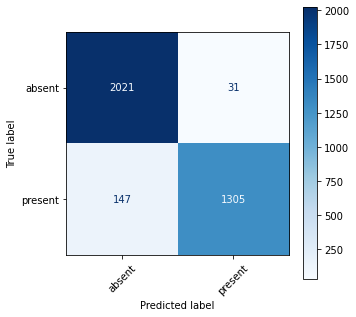

In [50]:
# Best params:  {'activation': 'relu', 'batch_size': 50, 'early_stopping': True, 'hidden_layer_sizes': (64, 64, 64), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 50, 'n_iter_no_change': 10, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'validation_fraction': 0.1}

params = {'activation': 'relu', 'batch_size': 50, 'early_stopping': True, 'hidden_layer_sizes': (64, 64, 64), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 50, 'n_iter_no_change': 10, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'validation_fraction': 0.1}

classifier = MLPClassifier(**params)
classifier.fit(X_train.values, y_train)

y_predicted = classifier.predict(X_val.values)

evaluation_classifier(y_predicted, y_val)
c = confusion_matrix(y_val, y_predicted)
plot_confusion_matrix(c, classifier)

Accuracy:  0.9514840182648402
Precision [micro]:  0.9514840182648402
Precision [macro]:  0.9577282491720994
Sensitivity [micro]:  0.9514840182648402
Sensitivity [macro]:  0.9436751888905
F score [micro]:  0.9514840182648402
F score [macro]:  0.9493078851564215
Precision [all]:  [0.93204775 0.98340875]
F score [all]:  [0.95981087 0.9388049 ]
Sensitivity [all]:  [0.98927875 0.89807163]


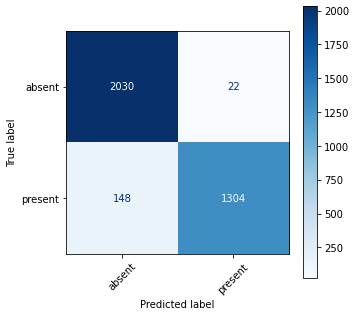

In [51]:
y_predicted = classifier.predict(X_test)

evaluation_classifier(y_predicted, y_test)
c = confusion_matrix(y_test, y_predicted)
plot_confusion_matrix(c, classifier)